# 1. Load Data
------

In [1]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [2]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

100%|██████████| 1.54M/1.54M [00:00<00:00, 54.1MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/jonassouza872/vitoria-da-conquista-weather-data-september/versions/1
['temp.csv']


In [3]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

Timestamp  Temp_MPU6050_C  Temp_AHT20_C  Umid_AHT20_pct  \
0  2025-08-31 22:31:02           20.86         19.90           73.37   
1  2025-08-31 22:31:33           21.75         19.97           75.57   
2  2025-08-31 22:32:05           21.80         19.75           74.31   
3  2025-08-31 22:32:36           21.57         19.55           74.77   
4  2025-08-31 22:33:07           21.66         19.60           75.09   

   Temp_BMP280_C  Press_BMP280_hPa  Temp_BMP180_C  Press_BMP180_hPa  \
0          21.28            921.24          20.19            923.02   
1          21.48            921.12          20.27            923.04   
2          21.25            921.20          20.16            923.06   
3          21.07            921.15          20.06            922.99   
4          21.12            921.25          20.06            923.02   

   Temp_DS18B20_C  Temp_NTC_C  Temp_DHT11_C  Umid_DHT11_pct  
0           25.69       22.26         20.03            66.0  
1           23.81       20.73         20.02            66.0  
2           22.50       20.88         20.02            67.0  
3           21.31       20.62         20.01            66.0  
4           21.88       20.95         20.00            66.0

In [4]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Moving Average Filter Analysis

--------------

The moving average filter is a signal processing technique that smooths time series data by averaging sliding subsets of points. Its primary function is to attenuate high-frequency sensor noise, revealing the underlying temperature trend without random fluctuations. However, selecting the window size requires a trade-off, as larger windows improve smoothing but introduce a lag in the system's response to actual environmental changes.

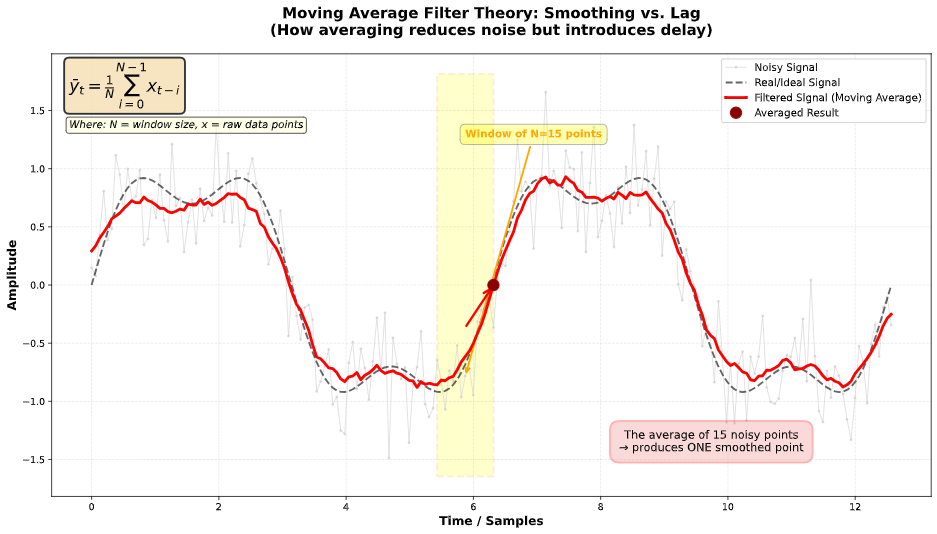

## 2.1. Temperature

----------

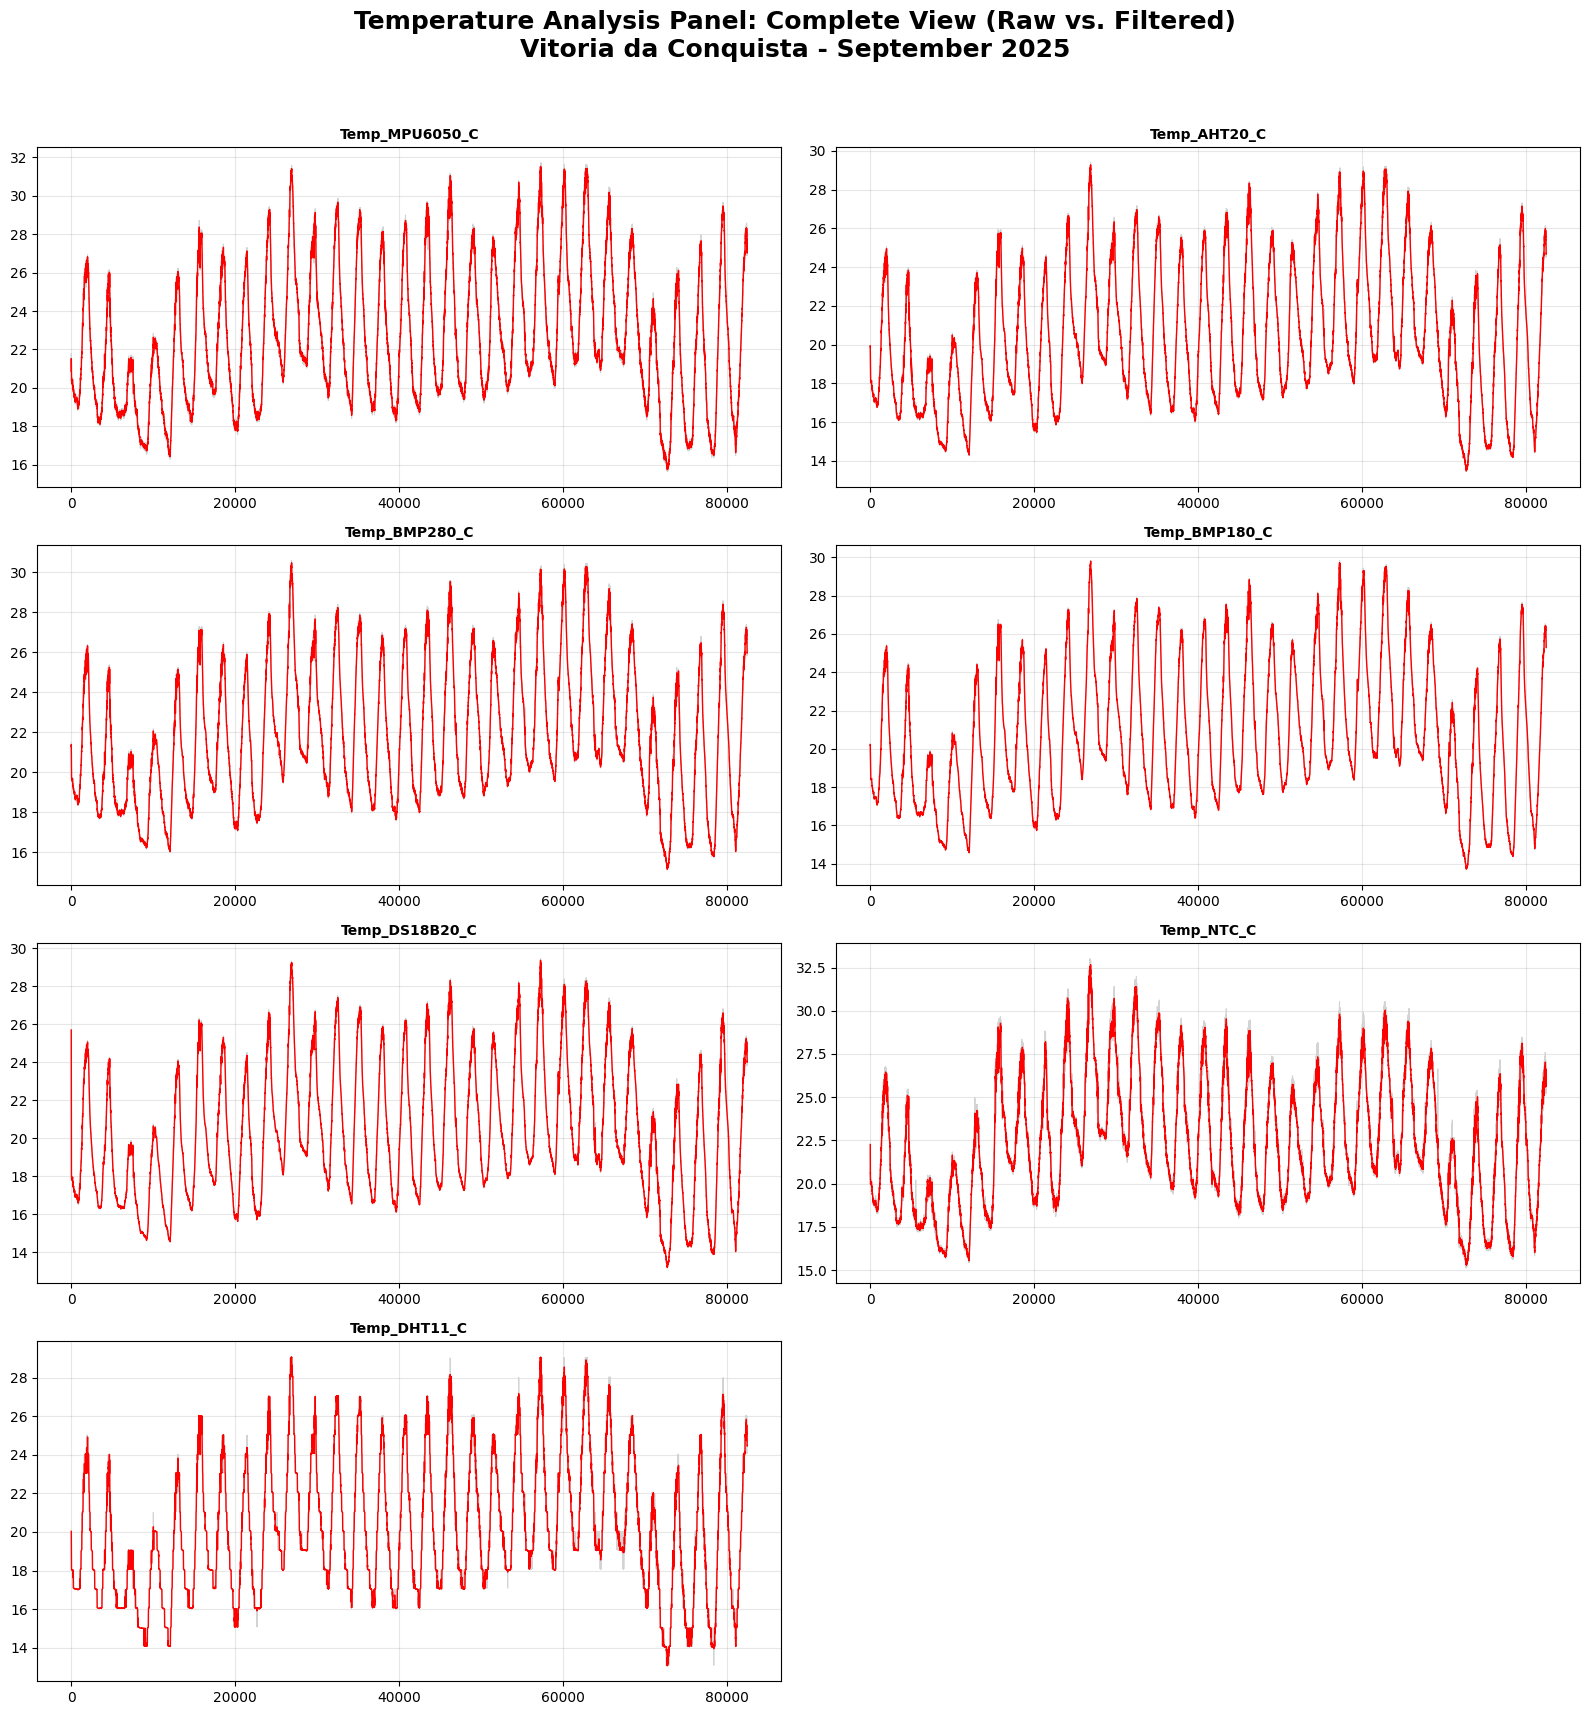

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

temp_sensors = [
    'Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
    'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C' #temperature sensors
]
fig, axes = plt.subplots(4, 2, figsize=(16, 18)) #Configure the subplot grid (4 rows x 2 columns)
#[[ax00, ax01],
# [ax10, ax11],
# [ax20, ax21],
# [ax30, ax31]]
axes = axes.flatten()# transforms the subplots into 1d matrix [ax00, ax01, ax10, ax11, ax20, ax21, ax30, ax31]

fig.suptitle("Temperature Analysis Panel: Complete View (Raw vs. Filtered)\nVitoria da Conquista - September 2025",
             fontsize=18, fontweight='bold', y=0.98)#title

for i, sensor in enumerate(temp_sensors):#for all temperature sensors
    ax = axes[i] #traverses the array, plotting one subplot at a time
    ideal_filter = df[sensor].rolling(window=10, min_periods=1).mean() #filter calculation considering window of 10 average
    #the .rolling method allows taking the last 10 values to calculate the average
    #The min_periods allows the model to start from the first value (takes average with 1 value)
    #not needing to wait to reach the 10th value to start the filter

    ax.plot(df.index, df[sensor], label='Original', color='lightgray', linewidth=0.8)#plots the original data
    ax.plot(df.index, ideal_filter, label='Filtered (W=10)', color='red', linewidth=1.0)#plots the filtered data from the measurement count
    ax.set_title(f'{sensor}', fontweight='bold', fontsize=10) #Subplot title being the sensor name
    ax.grid(True, alpha=0.3)

fig.delaxes(axes[7]) #removes the empty graph left over (there are 8 so the last one will be left over, since there are 7 sensors)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

- Due to high data density in the full-month view, the filtered line overlaps the raw signal, obscuring noise details. This macro scale hinders the visual assessment of the smoothing effect. Therefore, zooming into specific segments is necessary to properly evaluate the filter's performance.

                Window 10  Window 50  Window 100
Sensor                                          
Temp_MPU6050_C   0.121686   0.266368    0.441761
Temp_AHT20_C     0.103773   0.247871    0.420012
Temp_BMP280_C    0.100457   0.241377    0.409143
Temp_BMP180_C    0.075361   0.238258    0.424845
Temp_DS18B20_C   0.100938   0.244751    0.420086
Temp_NTC_C       0.236541   0.350421    0.485454
Temp_DHT11_C     0.236531   0.370702    0.510598


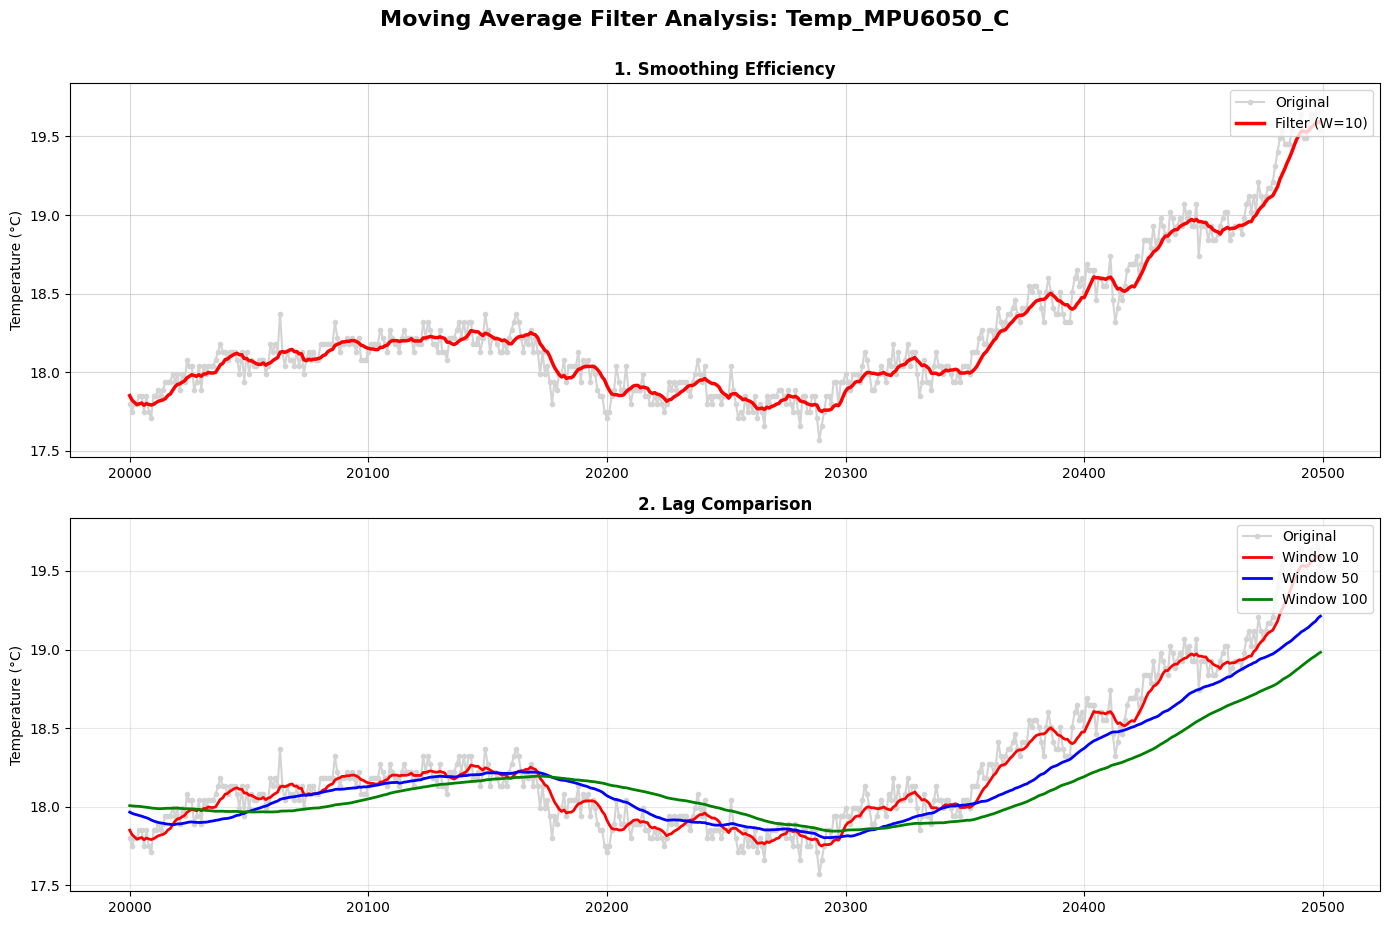

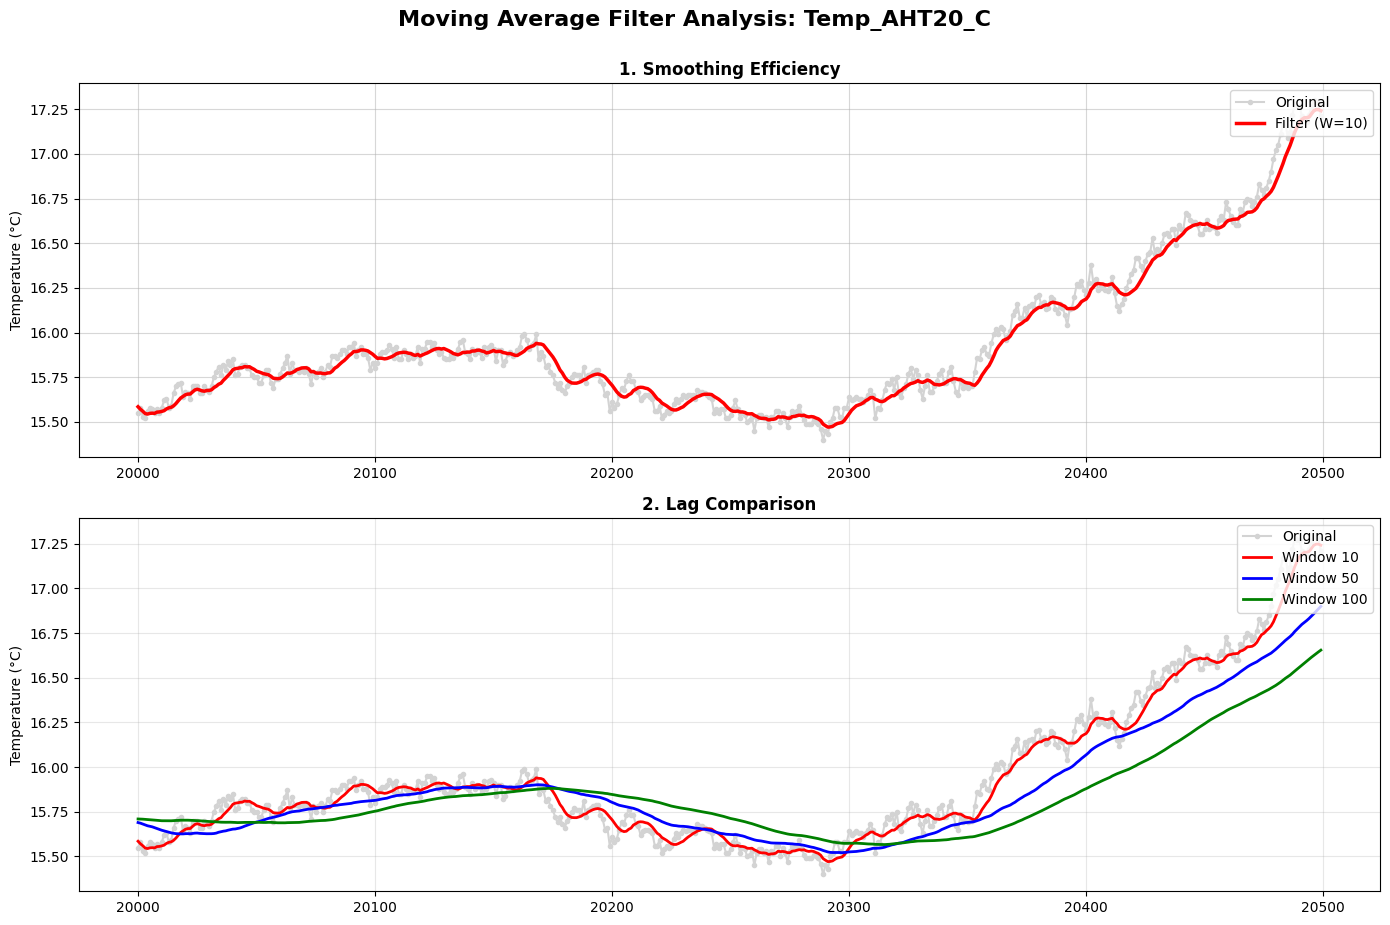

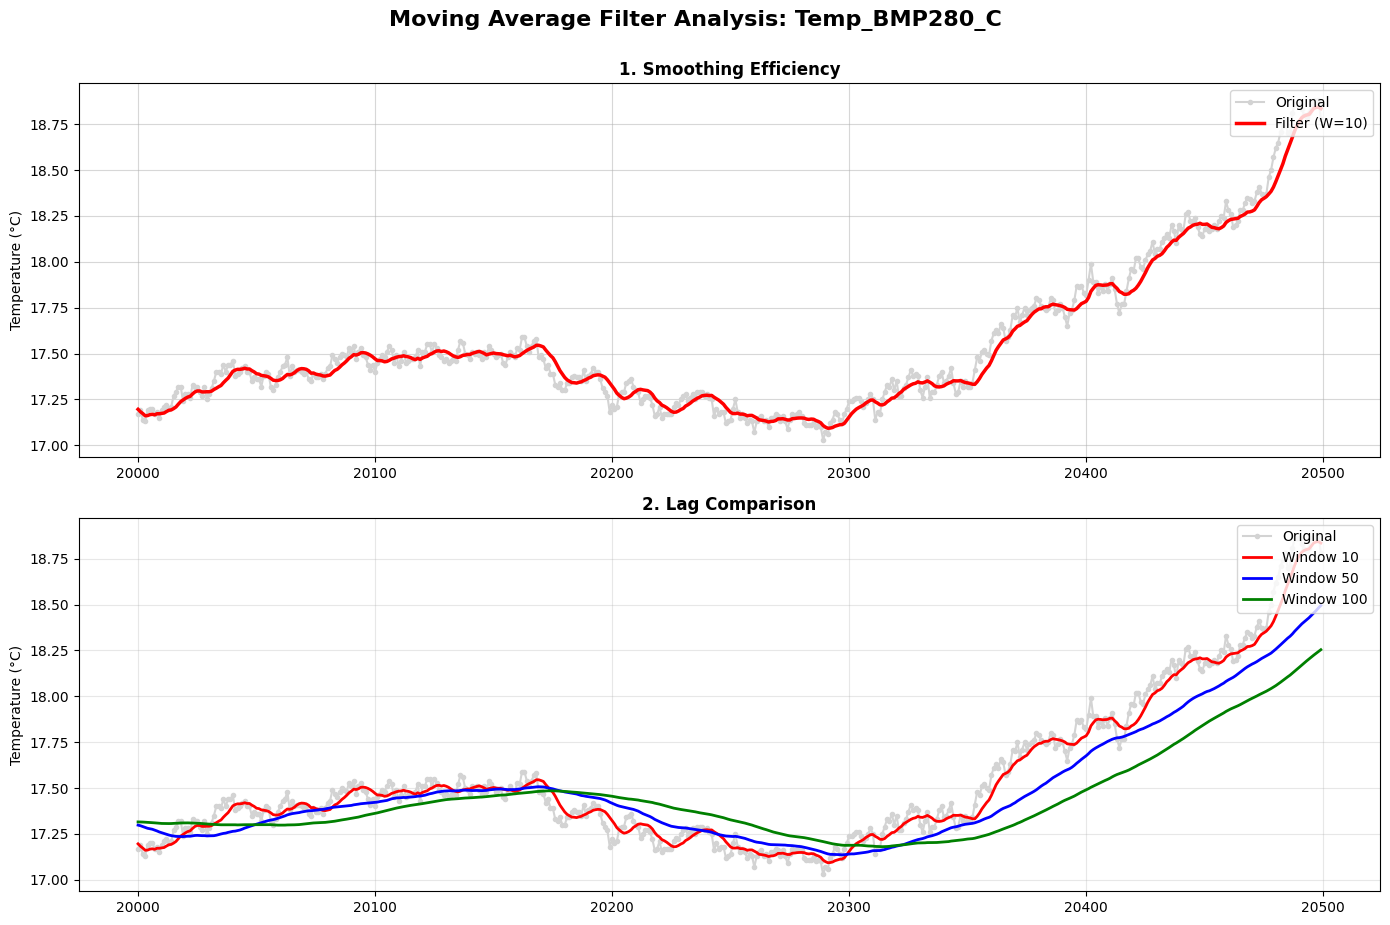

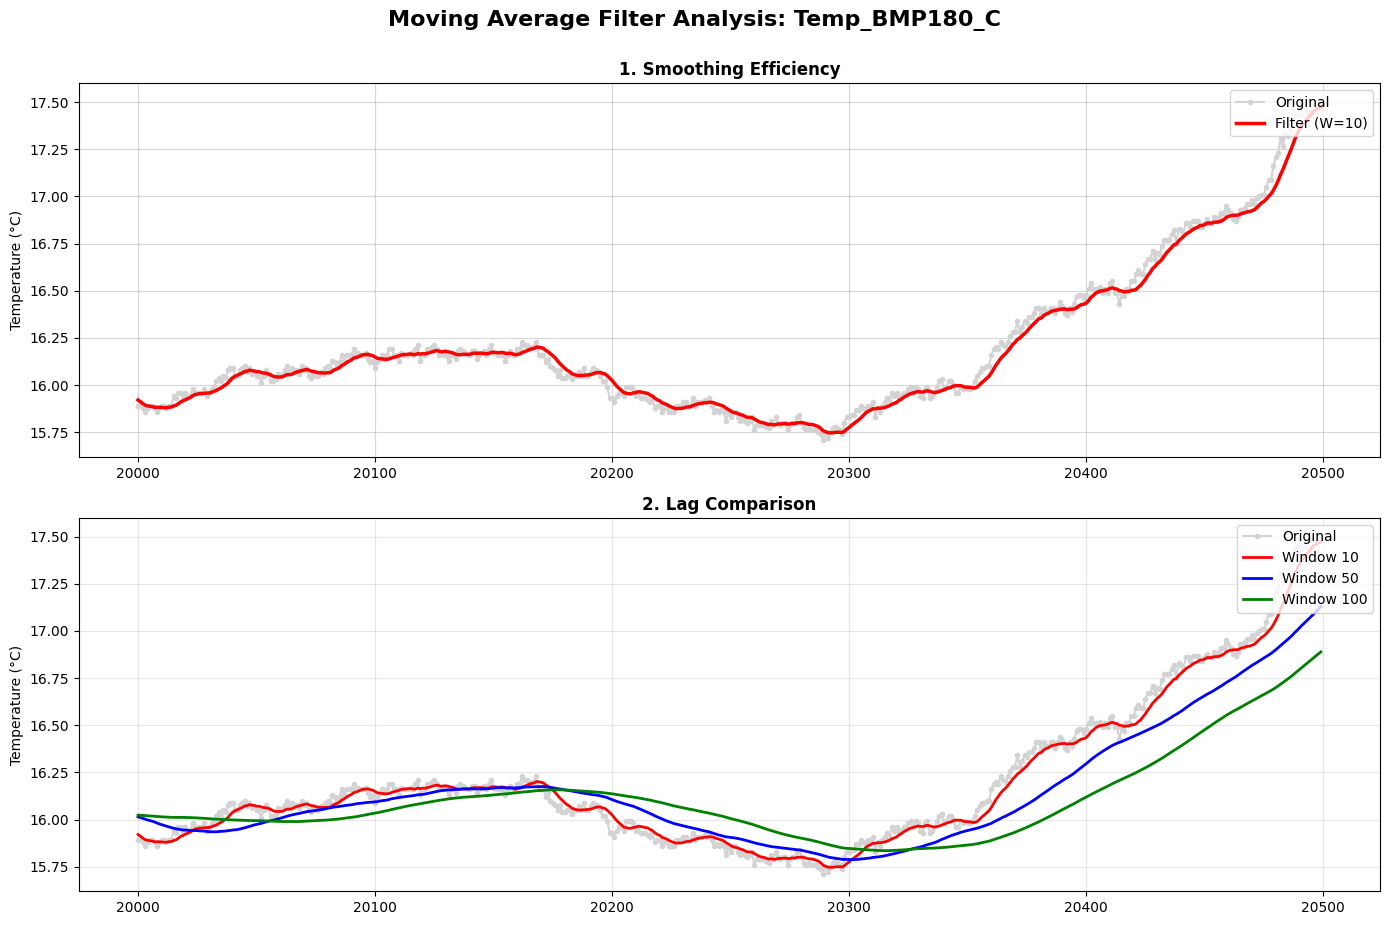

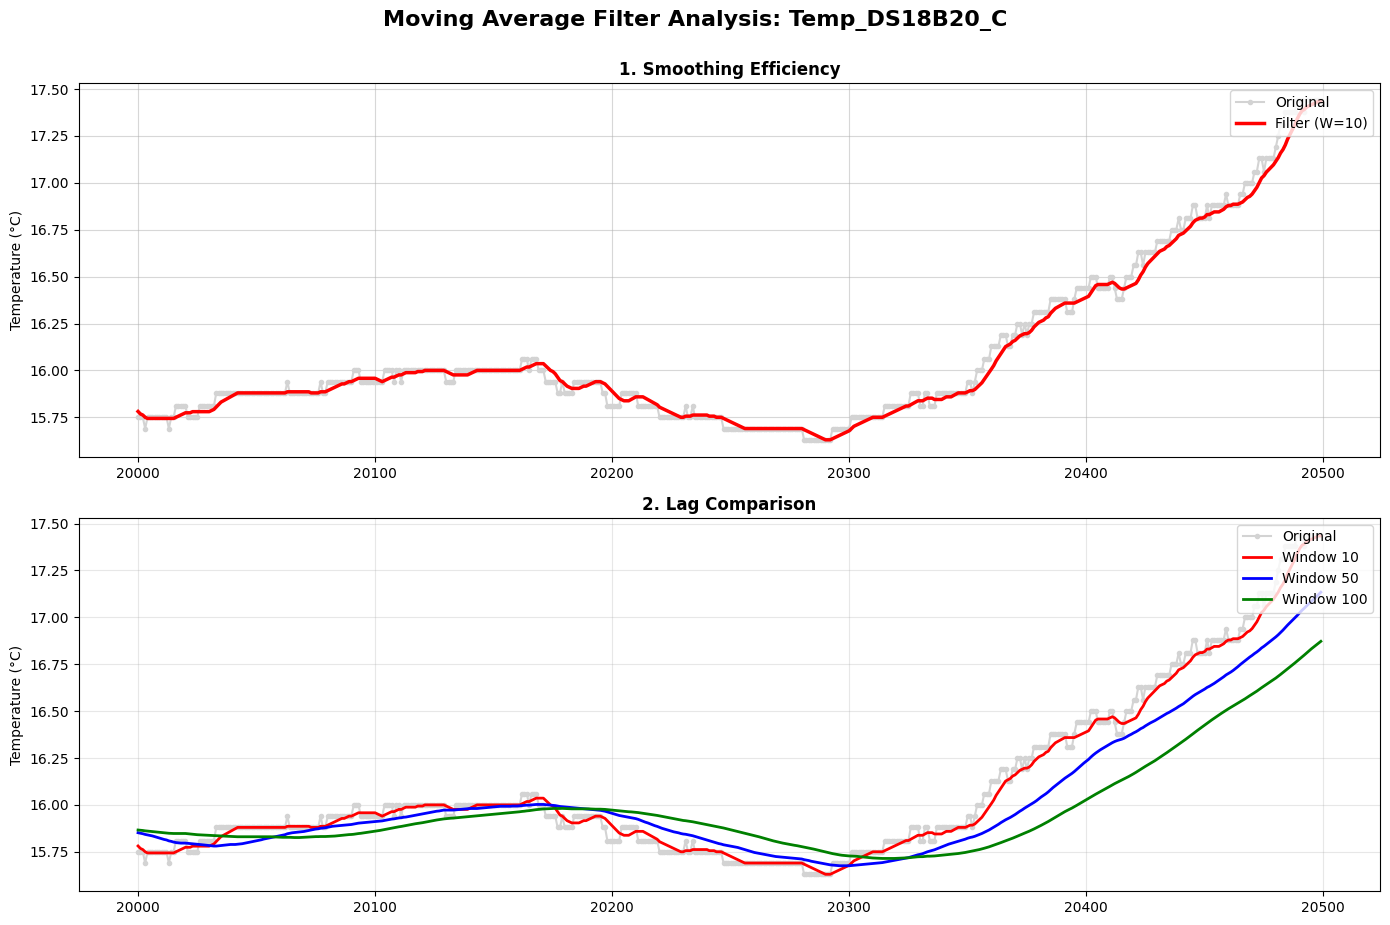

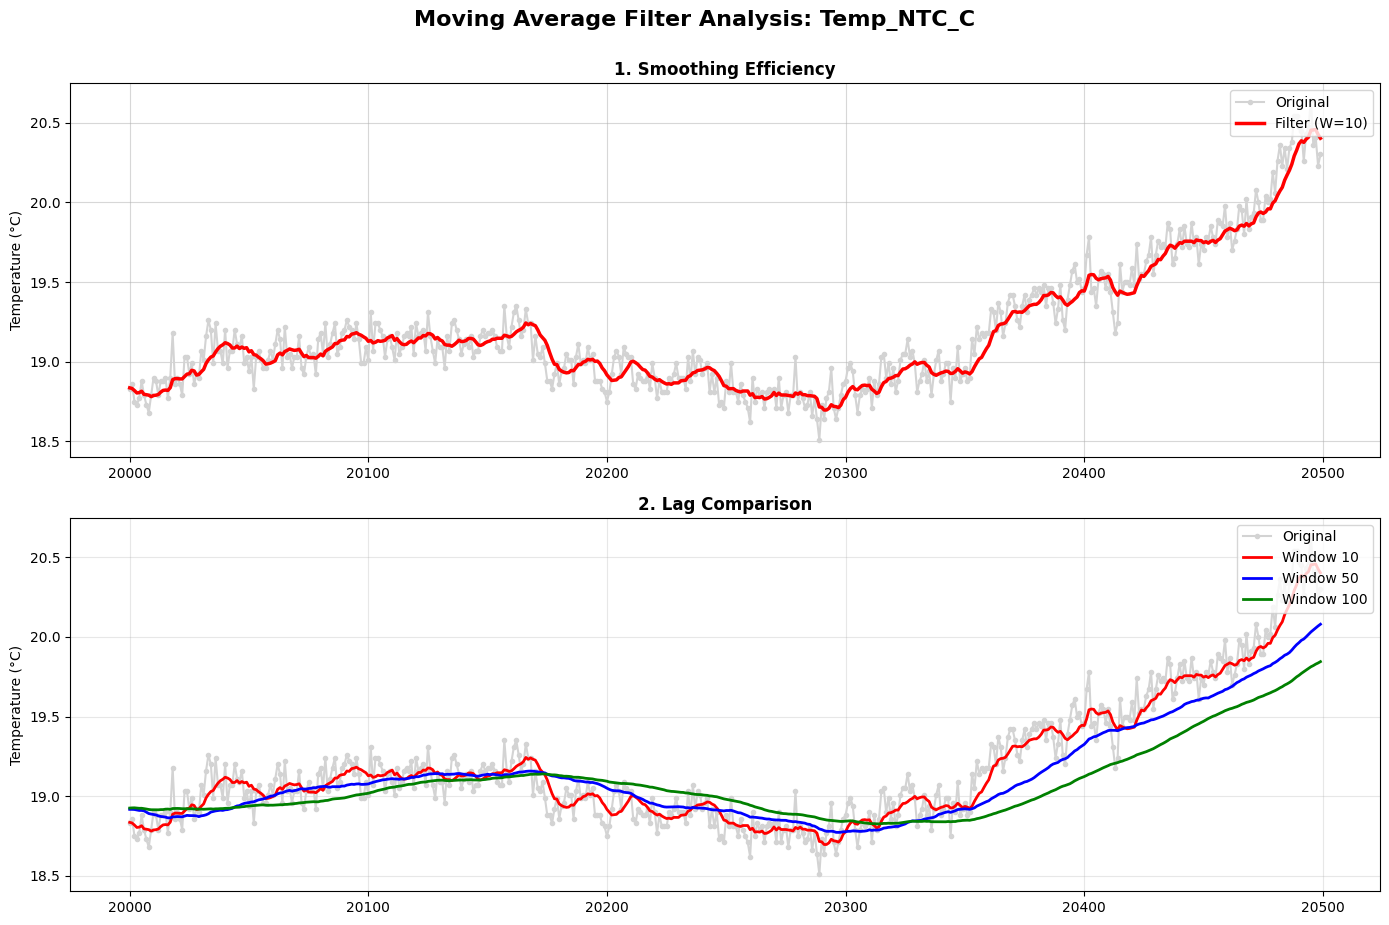

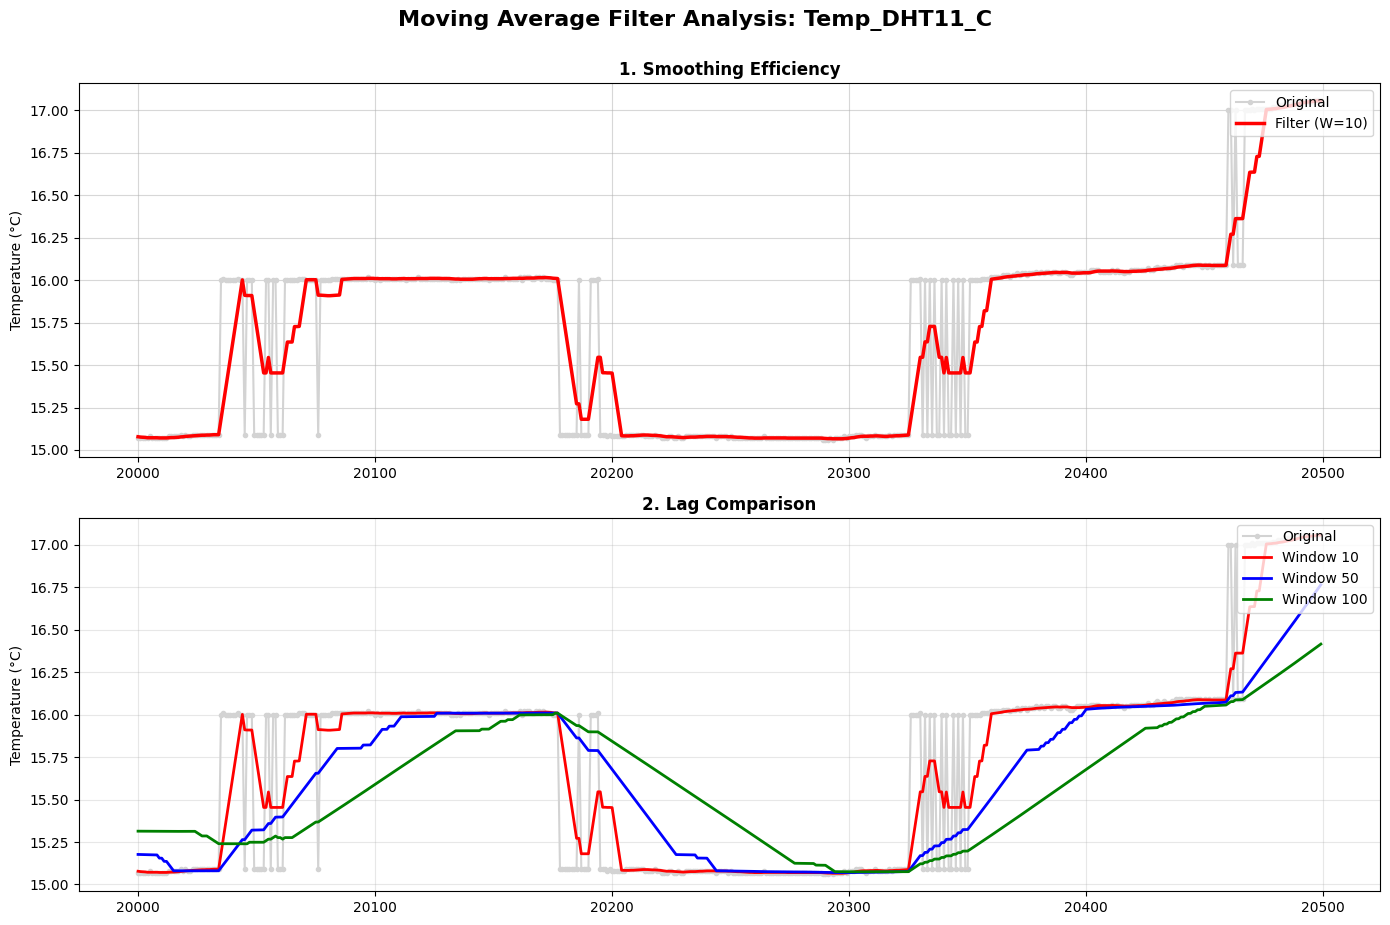

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

temp_sensors = [
    'Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
    'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C' #all sensors
]

test_windows = [10, 50, 100] #moving average window sizes to be evaluated
zoom_start = 20000 #start index for the zoomed view
zoom_end = 20500 #end index for the zoomed view (zoom window being 500 points)
colors = ['red', 'blue', 'green'] #color of each window curve
results = [] #list to store RMSE results

for sensor in temp_sensors: #for all sensors
    result_row = {'Sensor': sensor} #name of each sensor
    original = df[sensor]
    for w in test_windows: #iterates through all windows
        filtered = original.rolling(window=w, min_periods=1).mean() #applies rolling mean filter with current window size
        mask = ~np.isnan(original) & ~np.isnan(filtered) #mask to exclude NaN values
        rmse = np.sqrt(np.mean((original[mask] - filtered[mask])**2)) # RMSE calculation -> square root of average of (real value - filtered value)^2
        result_row[f'Window {w}'] = rmse #stores RMSE value for the current window
    results.append(result_row) #adds result to results list
df_results = pd.DataFrame(results) #dataframe with results
df_results.set_index('Sensor', inplace=True) #set sensor name as the index
print(df_results) #shows result for each sensor

for sensor in temp_sensors: #for all sensors
    df_zoom = df.iloc[zoom_start:zoom_end].copy() #create a data slice for the zoomed view (20000-20500)
    df_zoom['Ideal_Filter'] = df[sensor].rolling(window=10, min_periods=1).mean().iloc[zoom_start:zoom_end] #zoom plot comparing original vs filtered for window of 10
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10)) #plot
    fig.suptitle(f"Moving Average Filter Analysis: {sensor}", fontsize=16, fontweight='bold', y=0.95) #title

    #subplot 1: zoomed view
    ax1.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    ax1.plot(df_zoom.index, df_zoom['Ideal_Filter'], label='Filter (W=10)', color='red', linewidth=2.5)
    ax1.set_title('1. Smoothing Efficiency', fontweight='bold')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.5)
    #subplot 2: comparison of different window sizes
    ax2.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    for i, w in enumerate(test_windows): #for all declared windows
        temp_filter = df[sensor].rolling(window=w, min_periods=1).mean() #applies rolling mean filter with current window size
        filter_data_zoom = temp_filter.iloc[zoom_start:zoom_end]
        ax2.plot(df_zoom.index, filter_data_zoom, label=f'Window {w}', color=colors[i], linewidth=2) #plots filtered data for each window

    ax2.set_title('2. Lag Comparison', fontweight='bold')
    ax2.set_ylabel('Temperature (°C)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

- The analysis revealed that high-precision sensors maintained low initial error (RMSE ≈ 0.10 at window 10), contrasting with larger deviations in the DHT11 and NTC (RMSE ≈ 0.23) due to quantization and noise. The sharp rise in RMSE values to the 0.40–0.51 range at the 100-point window mathematically confirmed that excessive smoothing introduces unacceptable signal lag. Thus, the 10-point window was identified as the optimal balance, mitigating inconsistencies without compromising fidelity to the actual data.

## 2.2. Humidity

--------------------

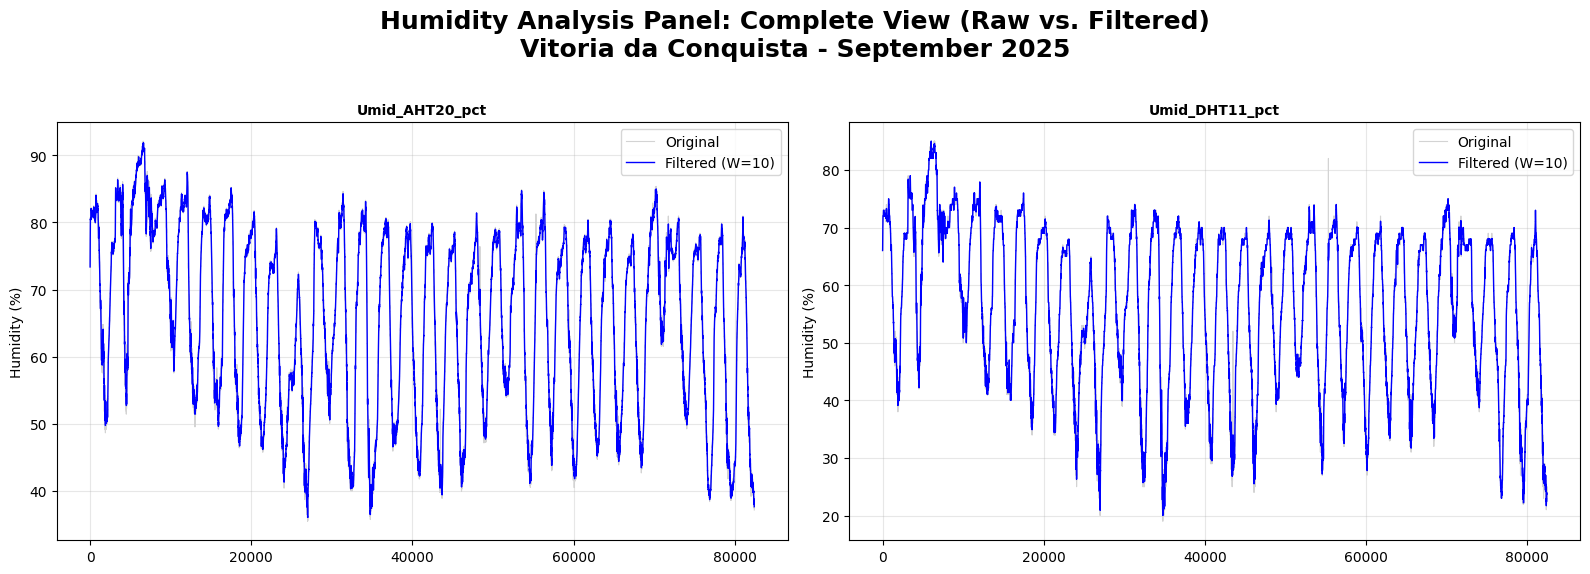

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

humidity_sensors = [
    'Umid_AHT20_pct', 'Umid_DHT11_pct' #humidity sensors
]
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) #Configure the subplot grid (1 row x 2 columns)

axes = axes.flatten()# transforms the subplots into 1d matrix

fig.suptitle("Humidity Analysis Panel: Complete View (Raw vs. Filtered)\nVitoria da Conquista - September 2025",
             fontsize=18, fontweight='bold', y=0.98)#title

for i, sensor in enumerate(humidity_sensors):#for all humidity sensors
    ax = axes[i] #traverses the array, plotting one subplot at a time
    ideal_filter = df[sensor].rolling(window=10, min_periods=1).mean() #filter calculation considering window of 10 average
    #the .rolling method allows taking the last 10 values to calculate the average
    #The min_periods allows the model to start from the first value (takes average with 1 value)
    #not needing to wait to reach the 10th value to start the filter

    ax.plot(df.index, df[sensor], label='Original', color='lightgray', linewidth=0.8)#plots the original data
    ax.plot(df.index, ideal_filter, label='Filtered (W=10)', color='blue', linewidth=1.0)#plots the filtered data from the measurement count
    ax.set_title(f'{sensor}', fontweight='bold', fontsize=10) #Subplot title being the sensor name
    ax.set_ylabel('Humidity (%)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

                Window 10  Window 50  Window 100
Sensor                                          
Umid_AHT20_pct   0.448741   1.102328    1.859353
Umid_DHT11_pct   0.567101   1.260553    2.000267


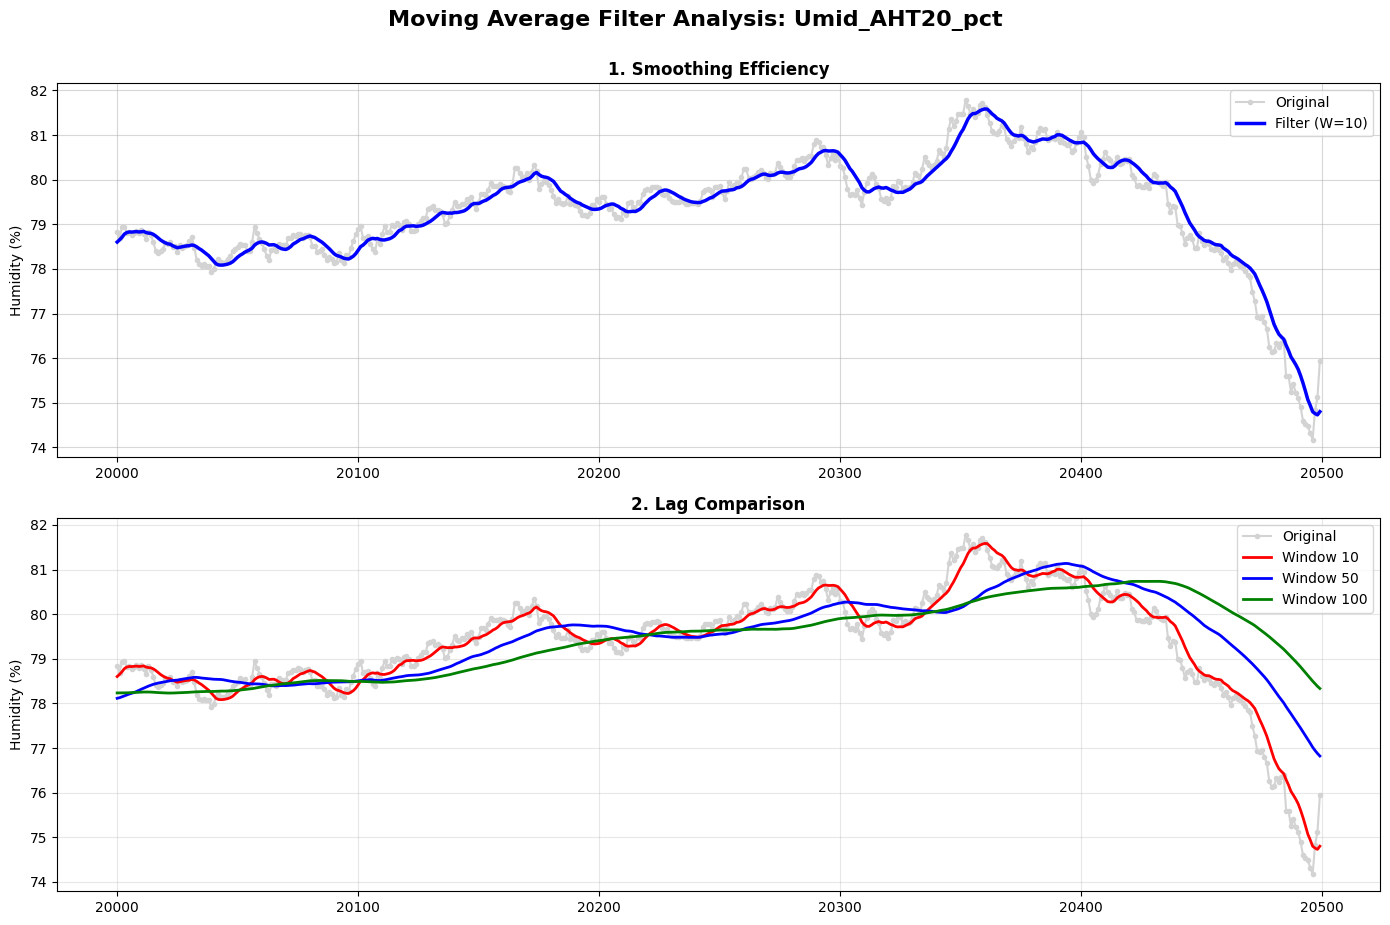

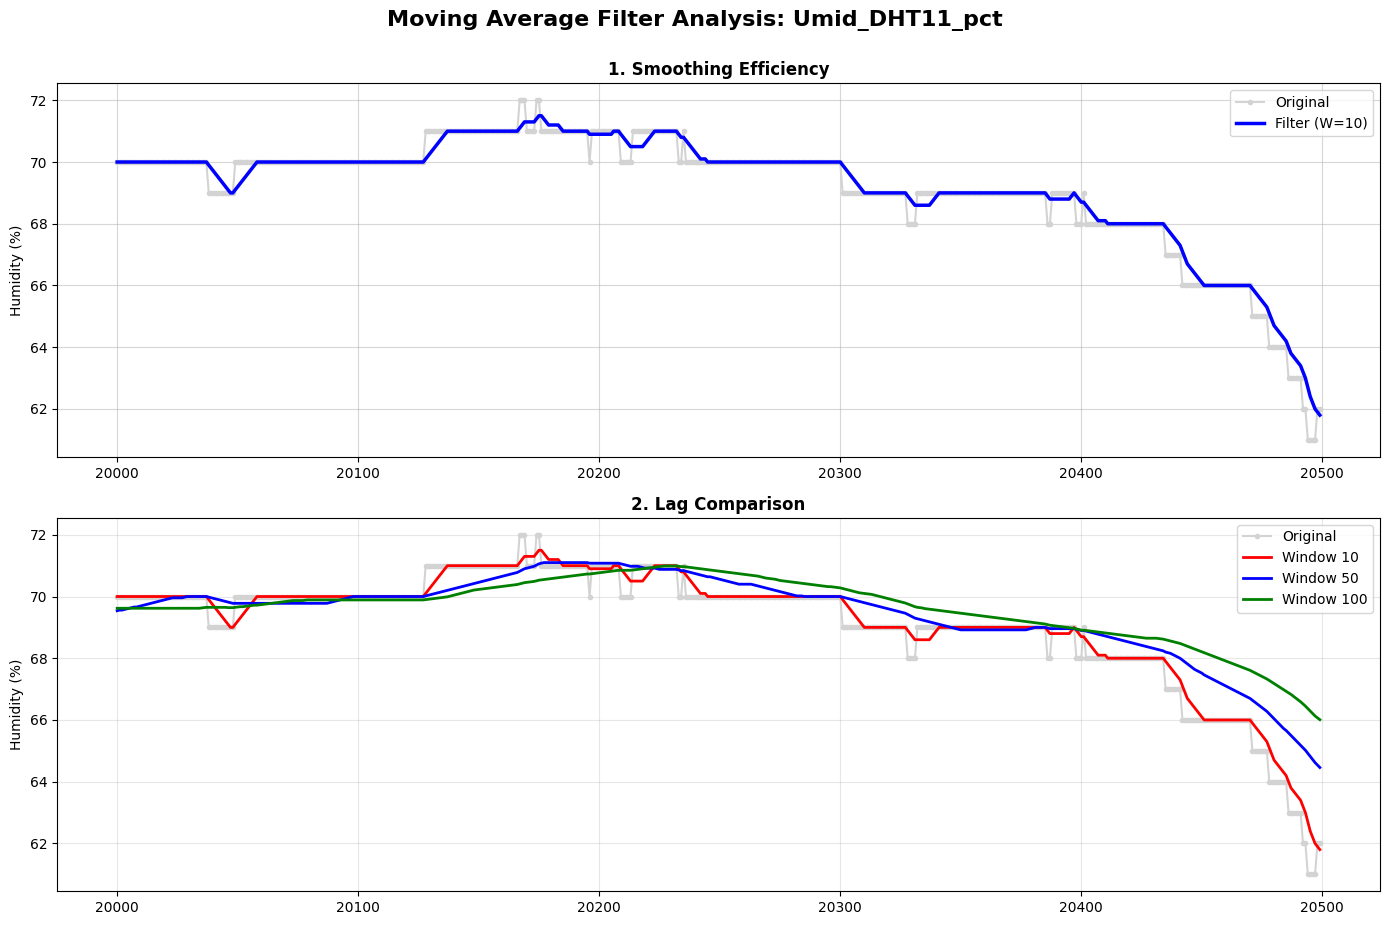

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

humidity_sensors = [
    'Umid_AHT20_pct', 'Umid_DHT11_pct' #all humidity sensors
]

test_windows = [10, 50, 100] #moving average window sizes to be evaluated
zoom_start = 20000 #start index for the zoomed view
zoom_end = 20500 #end index for the zoomed view (zoom window being 500 points)
colors = ['red', 'blue', 'green'] #color of each window curve
results = [] #list to store RMSE results

for sensor in humidity_sensors: #for all sensors
    result_row = {'Sensor': sensor} #name of each sensor
    original = df[sensor]
    for w in test_windows: #iterates through all windows
        filtered = original.rolling(window=w, min_periods=1).mean() #applies rolling mean filter with current window size
        mask = ~np.isnan(original) & ~np.isnan(filtered) #mask to exclude NaN values
        rmse = np.sqrt(np.mean((original[mask] - filtered[mask])**2)) # RMSE calculation -> square root of average of (real value - filtered value)^2
        result_row[f'Window {w}'] = rmse #stores RMSE value for the current window
    results.append(result_row) #adds result to results list
df_results = pd.DataFrame(results) #dataframe with results
df_results.set_index('Sensor', inplace=True) #set sensor name as the index
print(df_results) #shows result for each sensor

for sensor in humidity_sensors: #for all sensors
    df_zoom = df.iloc[zoom_start:zoom_end].copy() #create a data slice for the zoomed view (20000-20500)
    df_zoom['Ideal_Filter'] = df[sensor].rolling(window=10, min_periods=1).mean().iloc[zoom_start:zoom_end] #zoom plot comparing original vs filtered for window of 10
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10)) #plot
    fig.suptitle(f"Moving Average Filter Analysis: {sensor}", fontsize=16, fontweight='bold', y=0.95) #title

    #subplot 1: zoomed view
    ax1.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    ax1.plot(df_zoom.index, df_zoom['Ideal_Filter'], label='Filter (W=10)', color='blue', linewidth=2.5)
    ax1.set_title('1. Smoothing Efficiency', fontweight='bold')
    ax1.set_ylabel('Humidity (%)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.5)
    #subplot 2: comparison of different window sizes
    ax2.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    for i, w in enumerate(test_windows): #for all declared windows
        temp_filter = df[sensor].rolling(window=w, min_periods=1).mean() #applies rolling mean filter with current window size
        filter_data_zoom = temp_filter.iloc[zoom_start:zoom_end]
        ax2.plot(df_zoom.index, filter_data_zoom, label=f'Window {w}', color=colors[i], linewidth=2) #plots filtered data for each window

    ax2.set_title('2. Lag Comparison', fontweight='bold')
    ax2.set_ylabel('Humidity (%)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

The moving average filter analysis applied to humidity sensors revealed that the AHT20 demonstrated superior performance compared to the DHT11 across all window configurations, with consistently lower RMSE (0.449 vs 0.567 for W=10), reflecting its higher resolution and lower intrinsic noise. The expected pattern of progressive RMSE increase with window size (10→50→100) was observed in both sensors, evidencing the fundamental trade-off between smoothing and signal distortion, where larger windows remove more noise but introduce significant temporal lag and greater deviation from actual values (RMSE reaching ~2.0 percentage points for W=100 in DHT11). The 10-point window proved to be the optimal configuration for both sensors, minimizing RMSE (< 0.6 percentage points) while maintaining adequate temporal response to capture daily relative humidity variations. The DHT11, due to its limited 1% RH resolution, exhibited much more pronounced high-frequency noise in the graphs, resulting in 26% higher RMSE than the AHT20 in the best configuration, confirming its inadequacy for analyses requiring refined precision.

## 2.3. Pressure

------

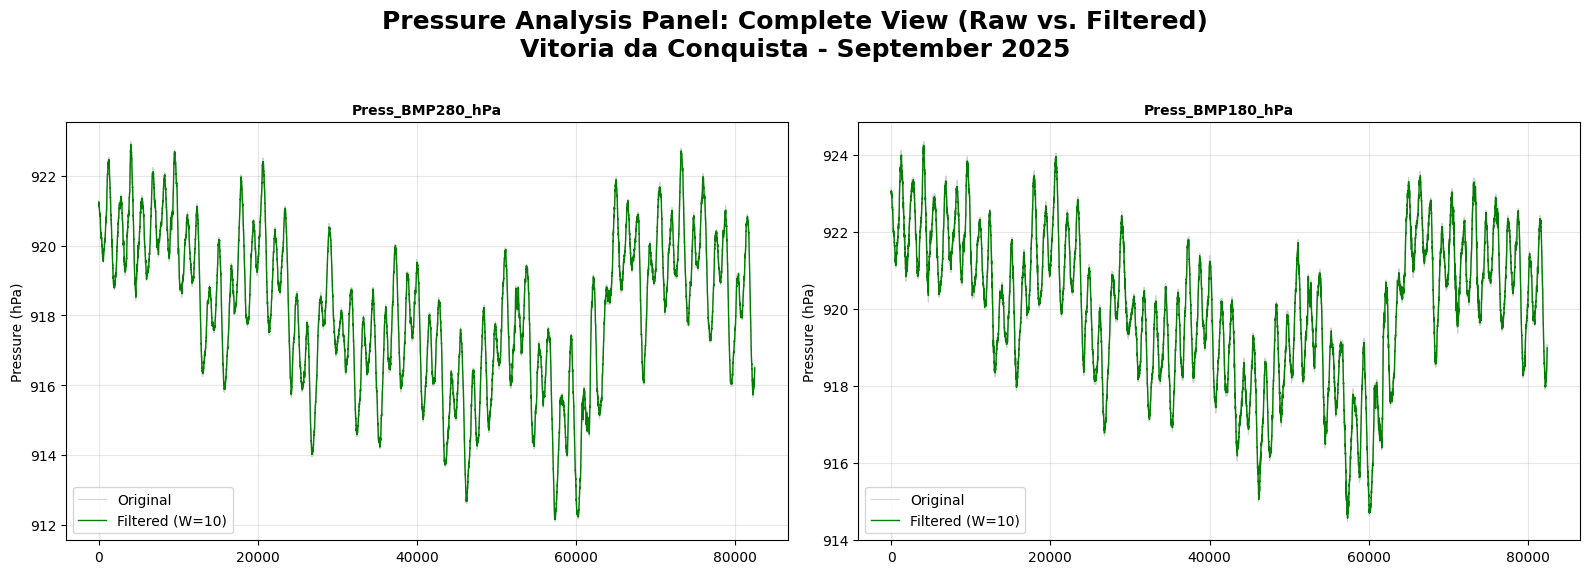

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pressure_sensors = [
    'Press_BMP280_hPa', 'Press_BMP180_hPa' #pressure sensors
]
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) #Configure the subplot grid (1 row x 2 columns)

axes = axes.flatten()# transforms the subplots into 1d matrix

fig.suptitle("Pressure Analysis Panel: Complete View (Raw vs. Filtered)\nVitoria da Conquista - September 2025",
             fontsize=18, fontweight='bold', y=0.98)#title

for i, sensor in enumerate(pressure_sensors):#for all pressure sensors
    ax = axes[i] #traverses the array, plotting one subplot at a time
    ideal_filter = df[sensor].rolling(window=10, min_periods=1).mean() #filter calculation considering window of 10 average
    #the .rolling method allows taking the last 10 values to calculate the average
    #The min_periods allows the model to start from the first value (takes average with 1 value)
    #not needing to wait to reach the 10th value to start the filter

    ax.plot(df.index, df[sensor], label='Original', color='lightgray', linewidth=0.8)#plots the original data
    ax.plot(df.index, ideal_filter, label='Filtered (W=10)', color='green', linewidth=1.0)#plots the filtered data from the measurement count
    ax.set_title(f'{sensor}', fontweight='bold', fontsize=10) #Subplot title being the sensor name
    ax.set_ylabel('Pressure (hPa)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

                  Window 10  Window 50  Window 100
Sensor                                            
Press_BMP280_hPa   0.048818   0.138377    0.254138
Press_BMP180_hPa   0.061758   0.139134    0.241596


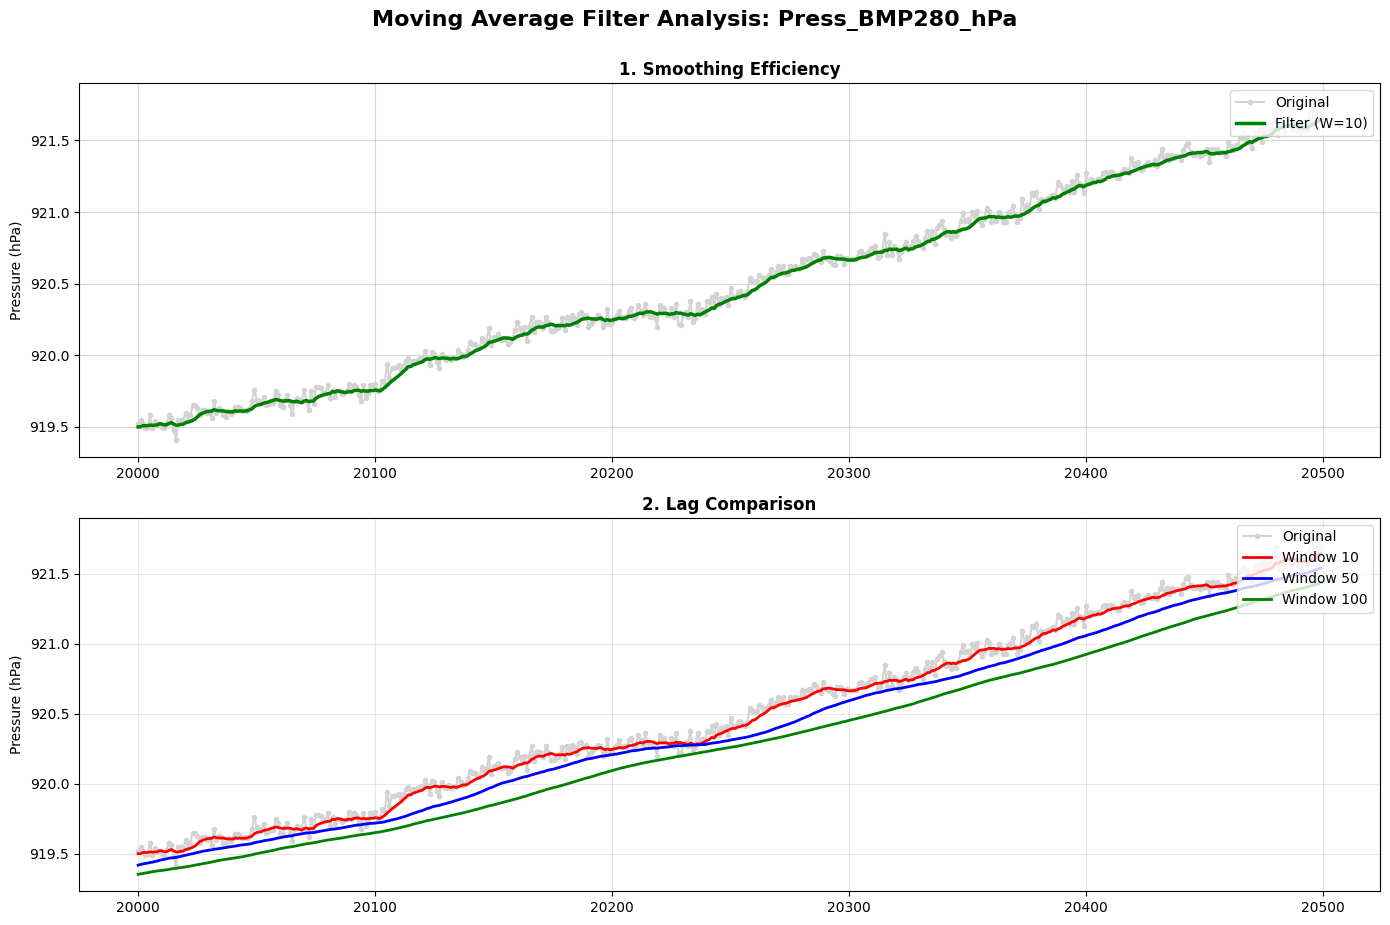

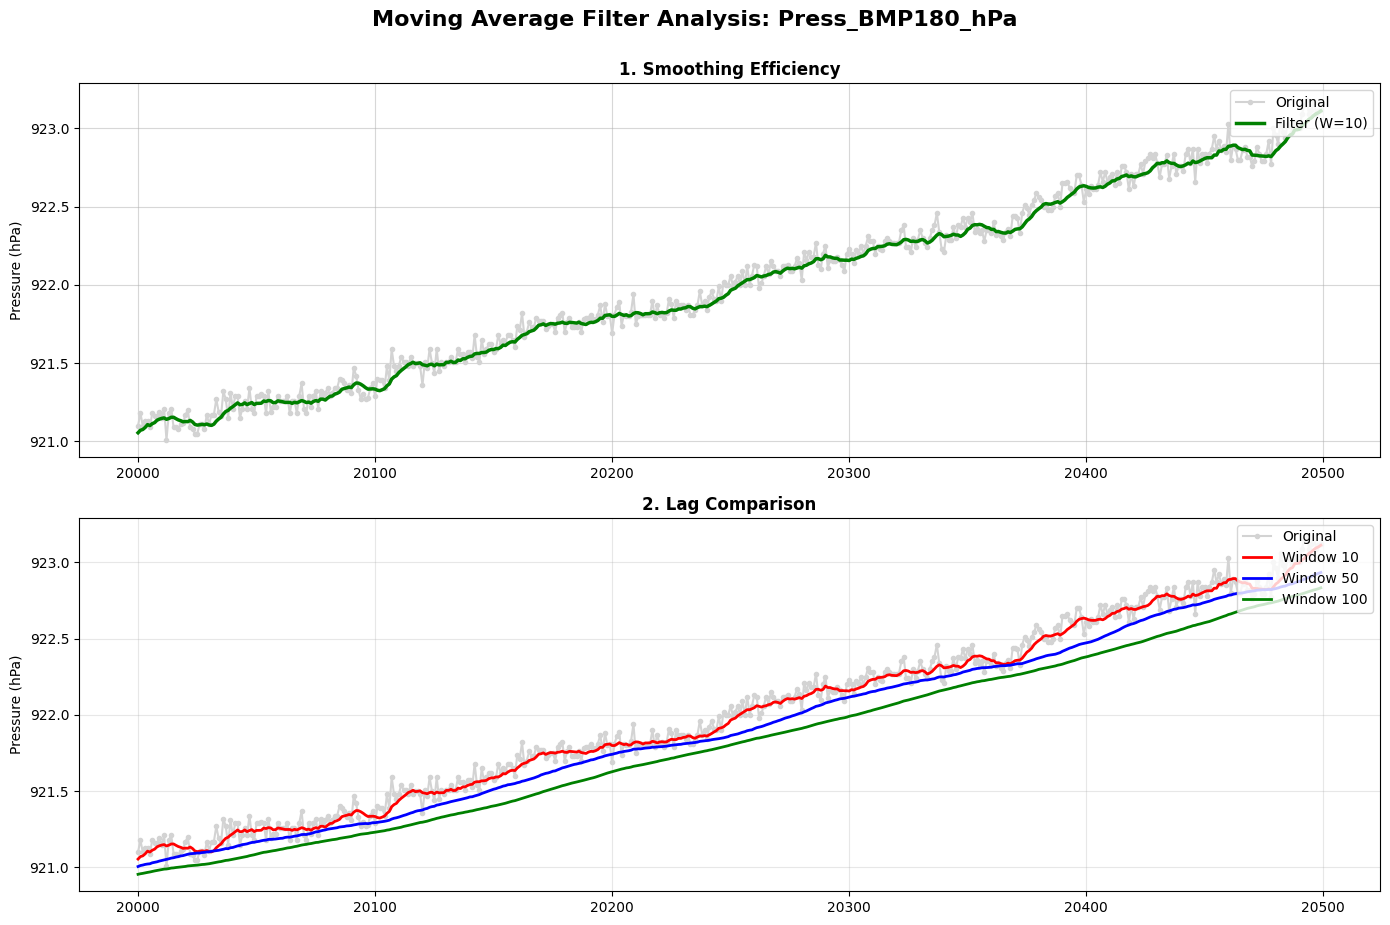

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pressure_sensors = [
    'Press_BMP280_hPa', 'Press_BMP180_hPa' #all pressure sensors
]

test_windows = [10, 50, 100] #moving average window sizes to be evaluated
zoom_start = 20000 #start index for the zoomed view
zoom_end = 20500 #end index for the zoomed view (zoom window being 500 points)
colors = ['red', 'blue', 'green'] #color of each window curve
results = [] #list to store RMSE results

for sensor in pressure_sensors: #for all sensors
    result_row = {'Sensor': sensor} #name of each sensor
    original = df[sensor]
    for w in test_windows: #iterates through all windows
        filtered = original.rolling(window=w, min_periods=1).mean() #applies rolling mean filter with current window size
        mask = ~np.isnan(original) & ~np.isnan(filtered) #mask to exclude NaN values
        rmse = np.sqrt(np.mean((original[mask] - filtered[mask])**2)) # RMSE calculation -> square root of average of (real value - filtered value)^2
        result_row[f'Window {w}'] = rmse #stores RMSE value for the current window
    results.append(result_row) #adds result to results list
df_results = pd.DataFrame(results) #dataframe with results
df_results.set_index('Sensor', inplace=True) #set sensor name as the index
print(df_results) #shows result for each sensor

for sensor in pressure_sensors: #for all sensors
    df_zoom = df.iloc[zoom_start:zoom_end].copy() #create a data slice for the zoomed view (20000-20500)
    df_zoom['Ideal_Filter'] = df[sensor].rolling(window=10, min_periods=1).mean().iloc[zoom_start:zoom_end] #zoom plot comparing original vs filtered for window of 10
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10)) #plot
    fig.suptitle(f"Moving Average Filter Analysis: {sensor}", fontsize=16, fontweight='bold', y=0.95) #title

    #subplot 1: zoomed view
    ax1.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    ax1.plot(df_zoom.index, df_zoom['Ideal_Filter'], label='Filter (W=10)', color='green', linewidth=2.5)
    ax1.set_title('1. Smoothing Efficiency', fontweight='bold')
    ax1.set_ylabel('Pressure (hPa)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.5)
    #subplot 2: comparison of different window sizes
    ax2.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    for i, w in enumerate(test_windows): #for all declared windows
        temp_filter = df[sensor].rolling(window=w, min_periods=1).mean() #applies rolling mean filter with current window size
        filter_data_zoom = temp_filter.iloc[zoom_start:zoom_end]
        ax2.plot(df_zoom.index, filter_data_zoom, label=f'Window {w}', color=colors[i], linewidth=2) #plots filtered data for each window

    ax2.set_title('2. Lag Comparison', fontweight='bold')
    ax2.set_ylabel('Pressure (hPa)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

The moving average filter analysis applied to barometric sensors demonstrated exceptional performance with extremely low RMSE across all configurations, where the BMP280 showed slight superiority (0.049 hPa vs 0.062 hPa for W=10), reflecting the inherent stability of atmospheric pressure measurements compared to temperature and humidity. The pattern of progressive RMSE increase with window size was maintained (10→50→100), however with absolute values significantly lower than those observed in humidity, evidencing that atmospheric pressure exhibits slower and smoother variations over time with less high-frequency noise component. The 10-point window proved highly effective for both sensors, with RMSE below 0.07 hPa (negligible error considering the typical range of 920-923 hPa), while even larger windows (W=100) maintained acceptable error (~0.25 hPa), demonstrating that pressure tolerates greater smoothing without significant information loss. The graphs reveal a monotonic increasing pressure trend throughout the analyzed period (920→923 hPa), characteristic of synoptic-scale meteorological patterns, with minimal noise in the original signal that is efficiently removed by the filter. The remarkable convergence between BMP180 and BMP280 (RMSE difference < 0.015 hPa across all windows) validates the consistency of barometric measurements and confirms that W=10 is the optimal configuration, ensuring adequate temporal response with average error below 0.05 hPa for real-time atmospheric pressure monitoring.Tentar novamente

## 2.4. Root Mean Square Error (RMSE) Analysis

---------------

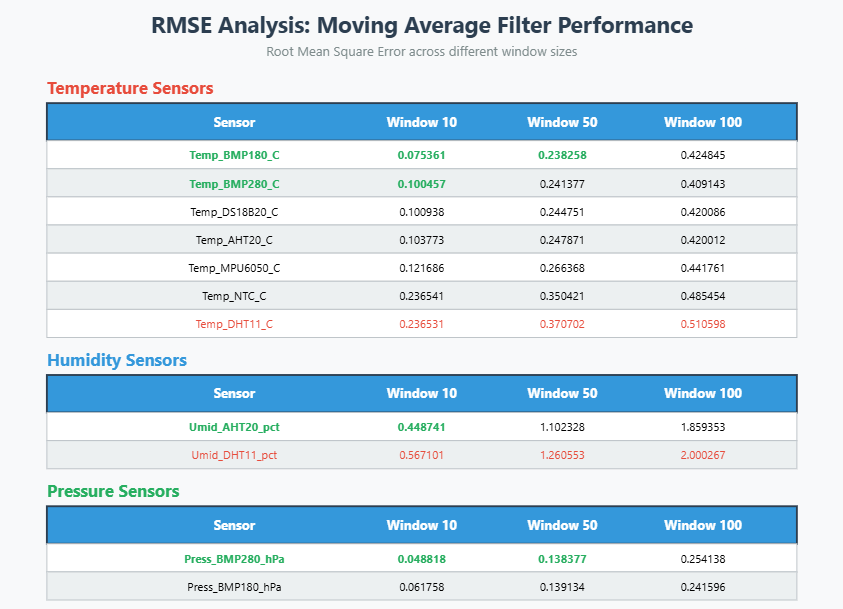

RMSE analysis revealed clear performance hierarchy: pressure sensors exhibited exceptionally low errors (0.049-0.062 hPa), temperature moderate errors (0.075-0.237°C), and humidity the highest errors (0.449-0.567%), reflecting the physical nature of each quantity and their temporal variation rates. The universal pattern of RMSE increase with window size (W10→W50→W100, growing 2-4×) confirmed the trade-off between smoothing and temporal fidelity, where larger windows remove more noise but distort instantaneous values. Bosch sensors (BMP180/BMP280) demonstrated consistent superiority with lowest RMSE in temperature and pressure, while DHT11 systematically showed 2-3× worse performance, confirming its inadequacy for precision applications. The W=10 configuration emerged as the universal optimum, offering excellent compromise between noise reduction and temporal response, with remarkably low RMSE: <0.08°C (BMP180), 0.45% (AHT20 humidity), and 0.05 hPa (BMP280 pressure).

# 3. Median Filter Implementation

-------


The median filter is a non-linear filter that replaces each value in the time series with the median of values within a sliding window, sorting the N points and selecting the central value (or the average of two central values if N is even). Unlike the moving average filter which computes the arithmetic mean, the median filter is highly effective at removing impulsive noise and extreme outliers, as the median is robust to atypical values that do not affect its central position after sorting. This characteristic makes it ideal for data with occasional spikes, salt-and-pepper noise, or sporadic erroneous sensor readings, better preserving edges and abrupt transitions in the signal compared to linear filters. The filter introduces less distortion in legitimate rapid signal changes, maintaining important features while eliminating anomalies, with the trade-off of higher computational cost due to the need for data sorting in each window. Window size selection follows similar logic to the moving average filter: small windows (3-5) preserve details and fast response, while larger windows (>10) offer greater smoothing at the cost of increased temporal lag.Tentar novamente

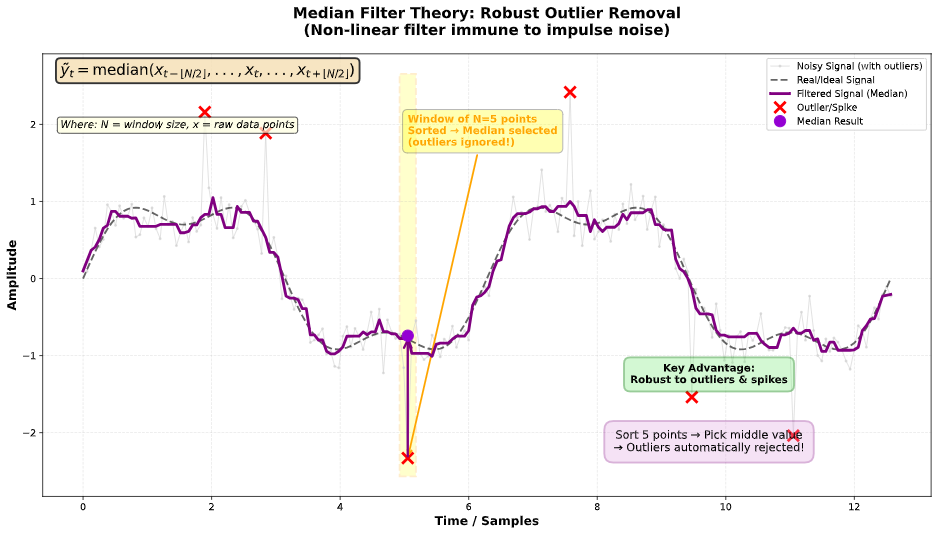

## 3.1. Temperature

-------------

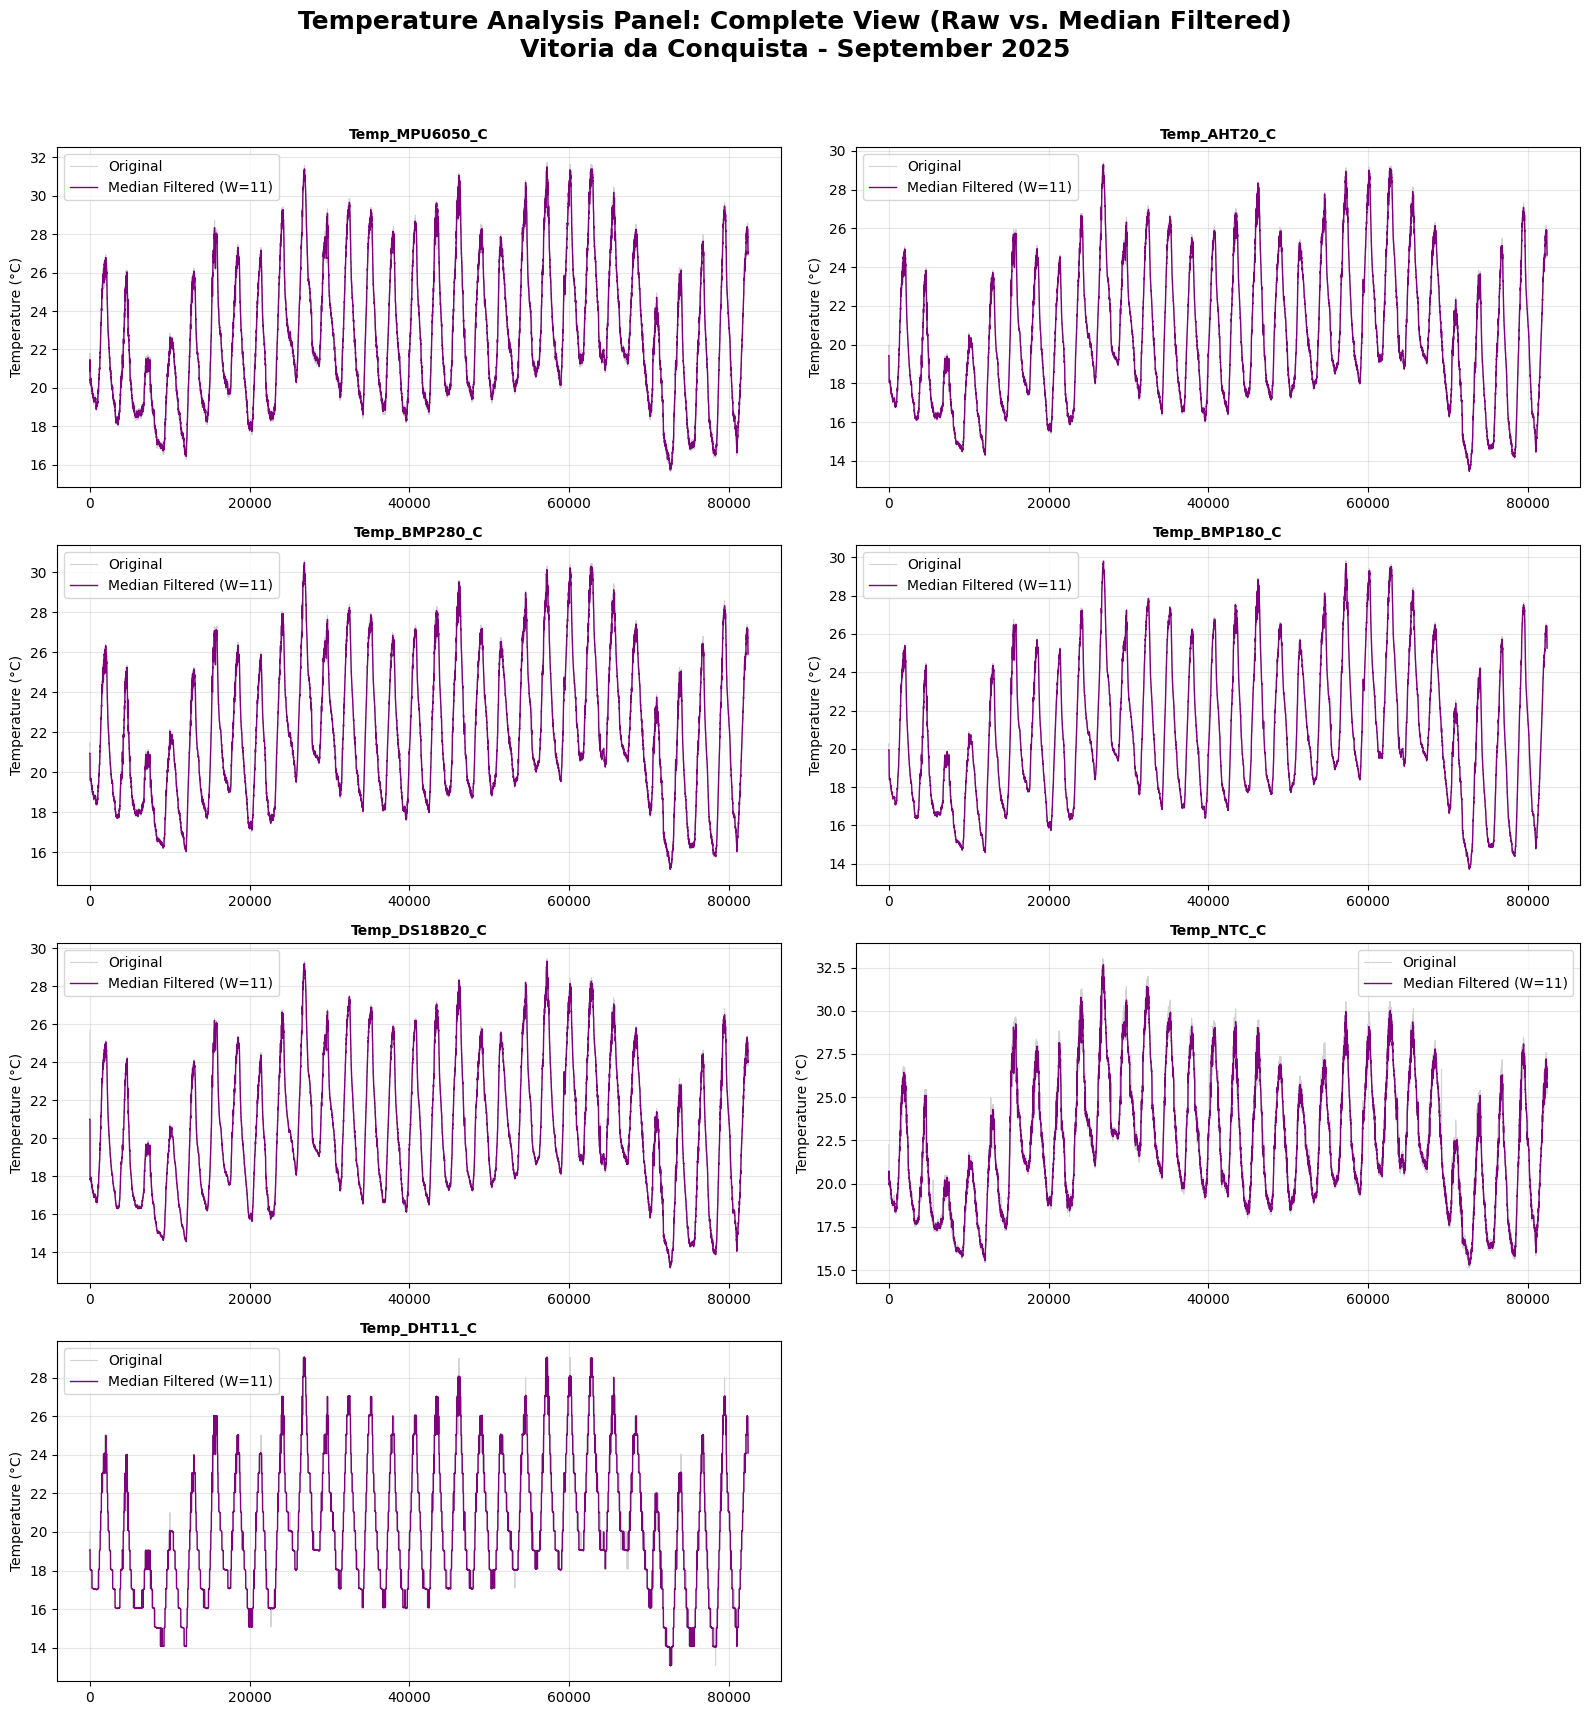

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

temp_sensors = [
    'Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
    'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C' #temperature sensors
]
fig, axes = plt.subplots(4, 2, figsize=(16, 18)) #Configure the subplot grid (4 rows x 2 columns)
#[[ax00, ax01],
# [ax10, ax11],
# [ax20, ax21],
# [ax30, ax31]]
axes = axes.flatten()# transforms the subplots into 1d matrix [ax00, ax01, ax10, ax11, ax20, ax21, ax30, ax31]

fig.suptitle("Temperature Analysis Panel: Complete View (Raw vs. Median Filtered)\nVitoria da Conquista - September 2025",
             fontsize=18, fontweight='bold', y=0.98)#title

for i, sensor in enumerate(temp_sensors):#for all temperature sensors
    ax = axes[i] #traverses the array, plotting one subplot at a time
    median_filter = medfilt(df[sensor].values, kernel_size=11) #median filter calculation considering window of 11
    #the medfilt function applies median filter by sorting values in the window and selecting the middle value
    #kernel_size must be odd number to have a clear center point
    #window of 11 means: takes 5 points before, current point, and 5 points after

    ax.plot(df.index, df[sensor], label='Original', color='lightgray', linewidth=0.8)#plots the original data
    ax.plot(df.index, median_filter, label='Median Filtered (W=11)', color='purple', linewidth=1.0)#plots the median filtered data
    ax.set_title(f'{sensor}', fontweight='bold', fontsize=10) #Subplot title being the sensor name
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

fig.delaxes(axes[7]) #removes the empty graph left over (there are 8 so the last one will be left over, since there are 7 sensors)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

                Window 5  Window 11  Window 21
Sensor                                        
Temp_MPU6050_C  0.062868   0.081262   0.100653
Temp_AHT20_C    0.035578   0.056148   0.078400
Temp_BMP280_C   0.032772   0.053157   0.075380
Temp_BMP180_C   0.021118   0.031460   0.046533
Temp_DS18B20_C  0.031117   0.051864   0.081481
Temp_NTC_C      0.175513   0.205209   0.228547
Temp_DHT11_C    0.209795   0.234949   0.254344


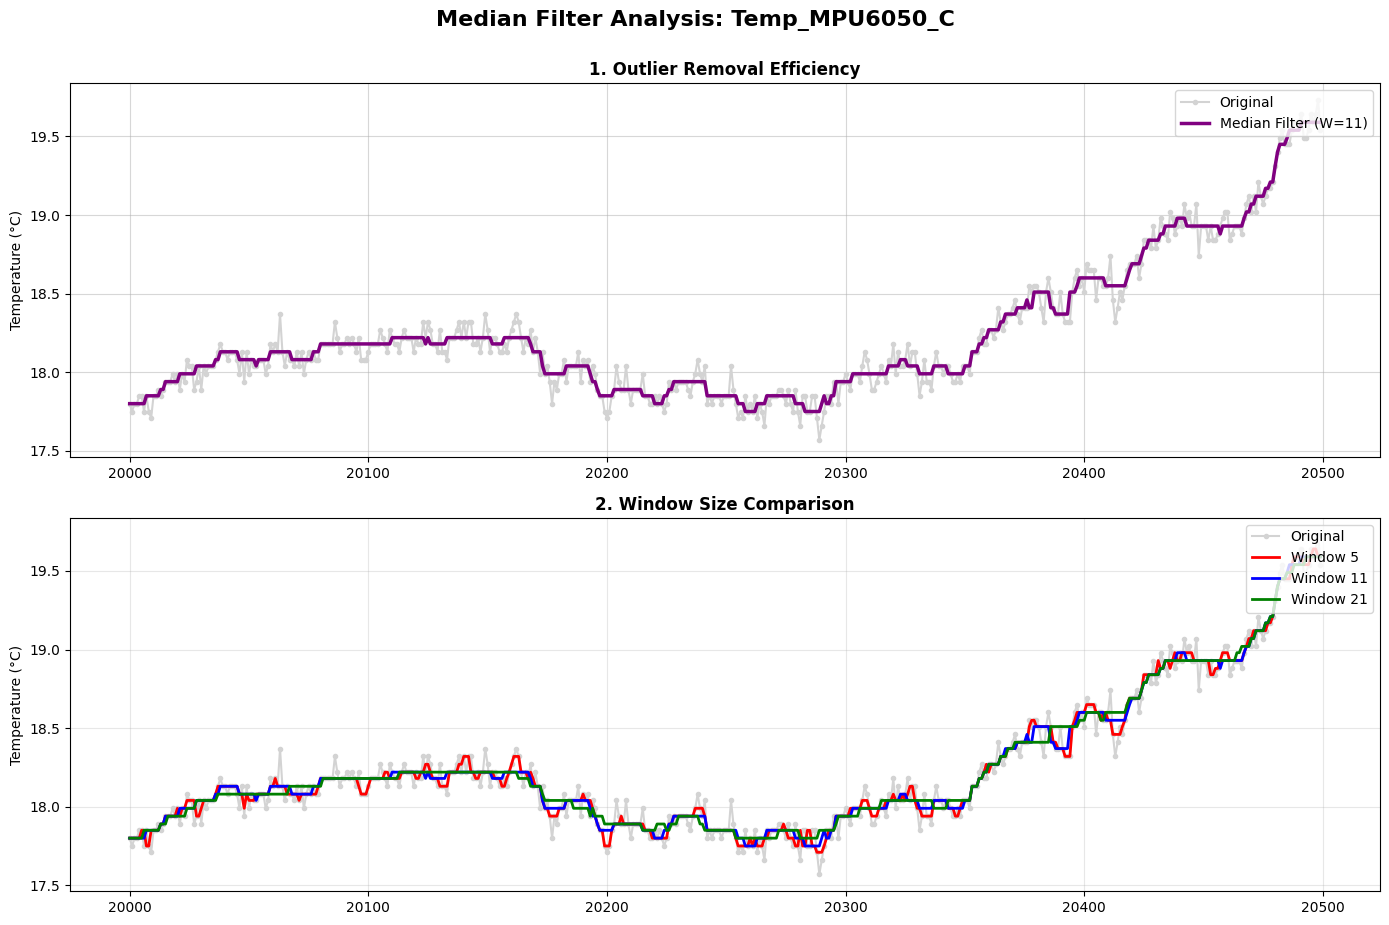

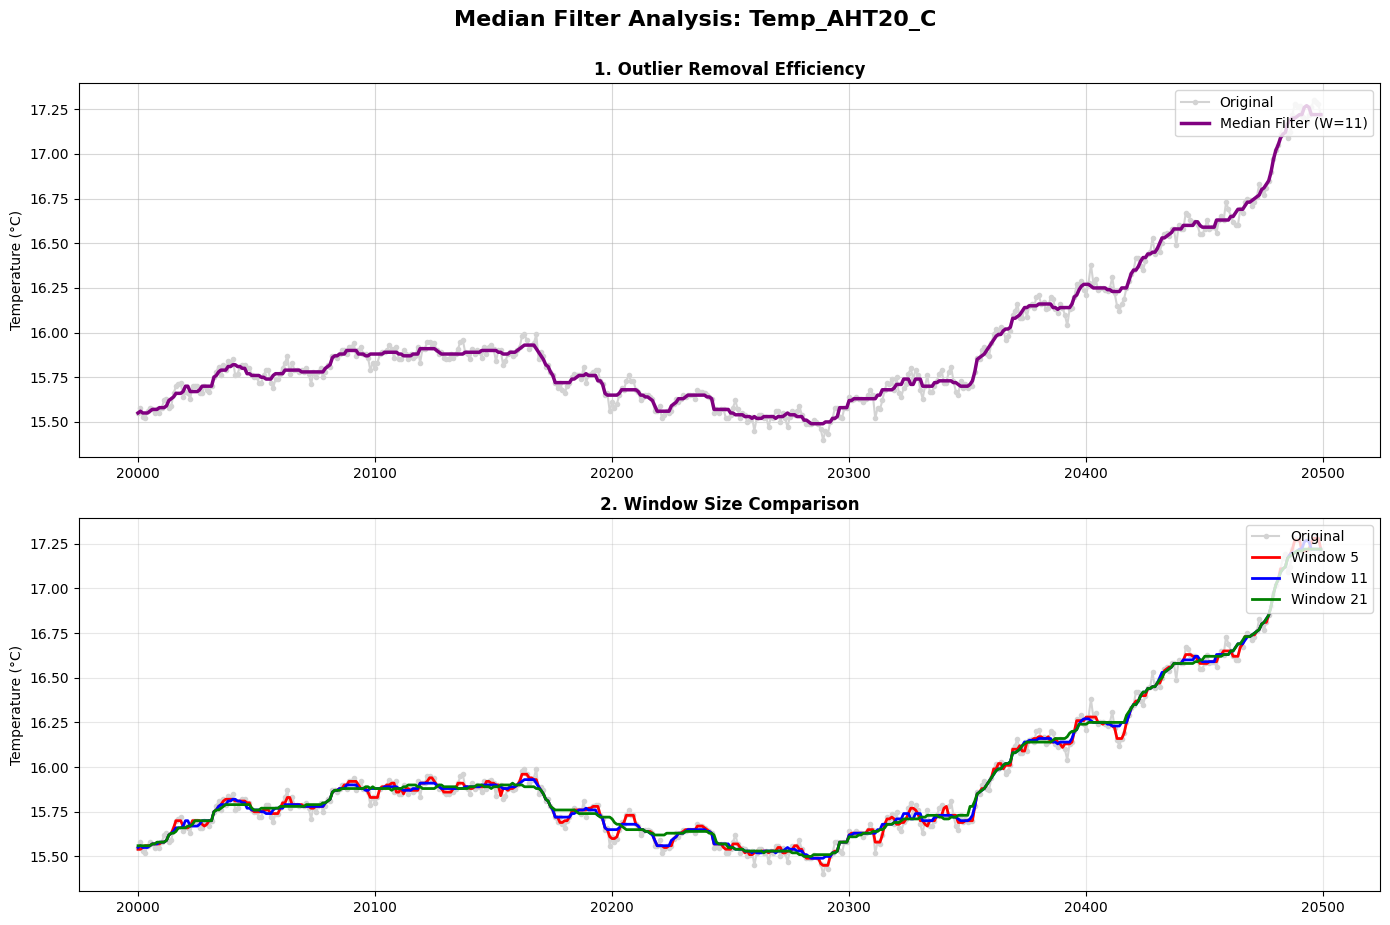

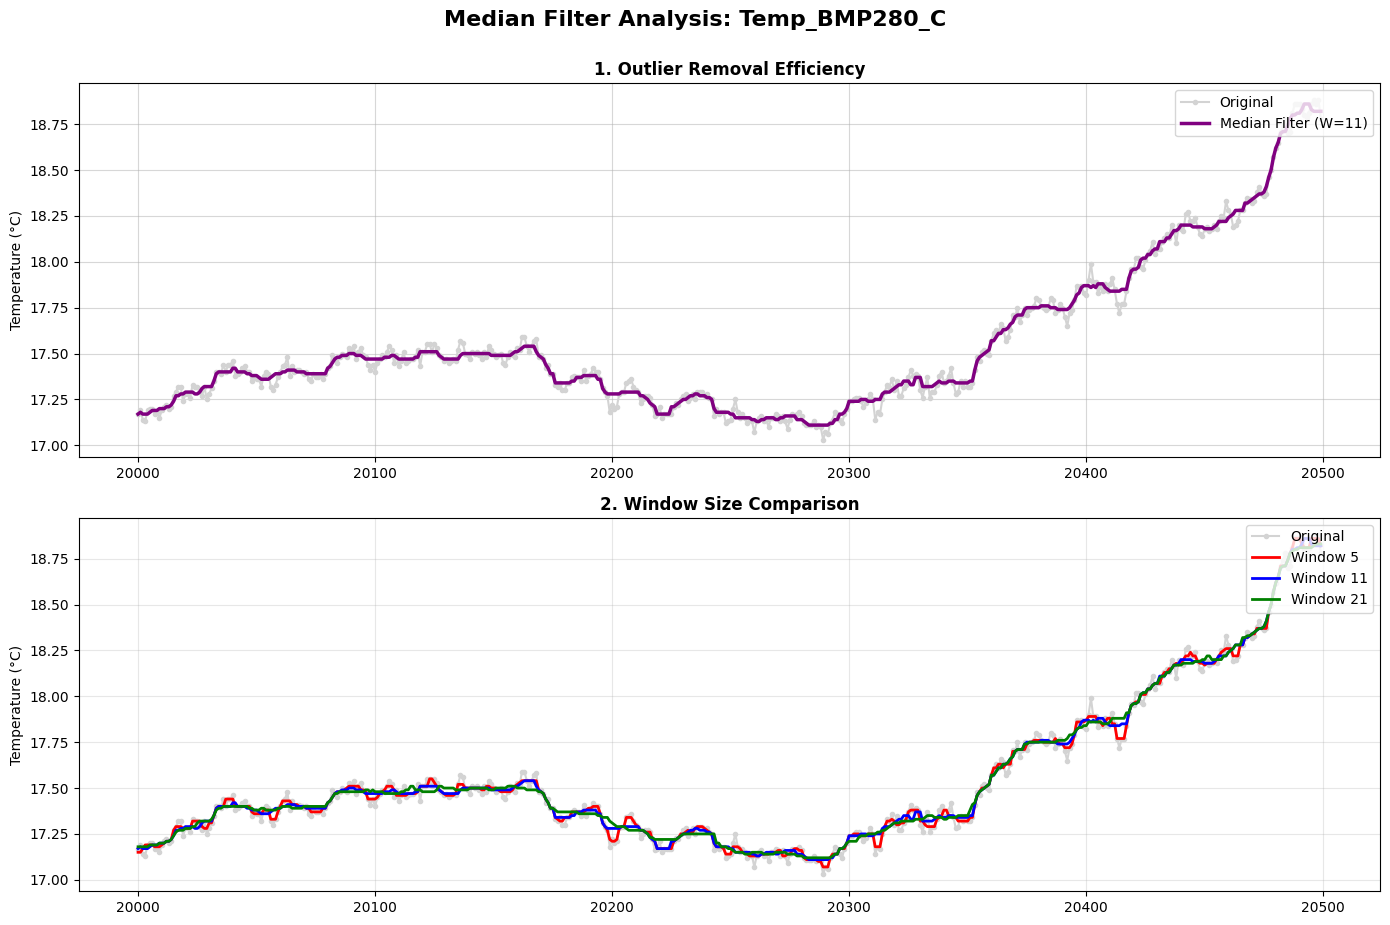

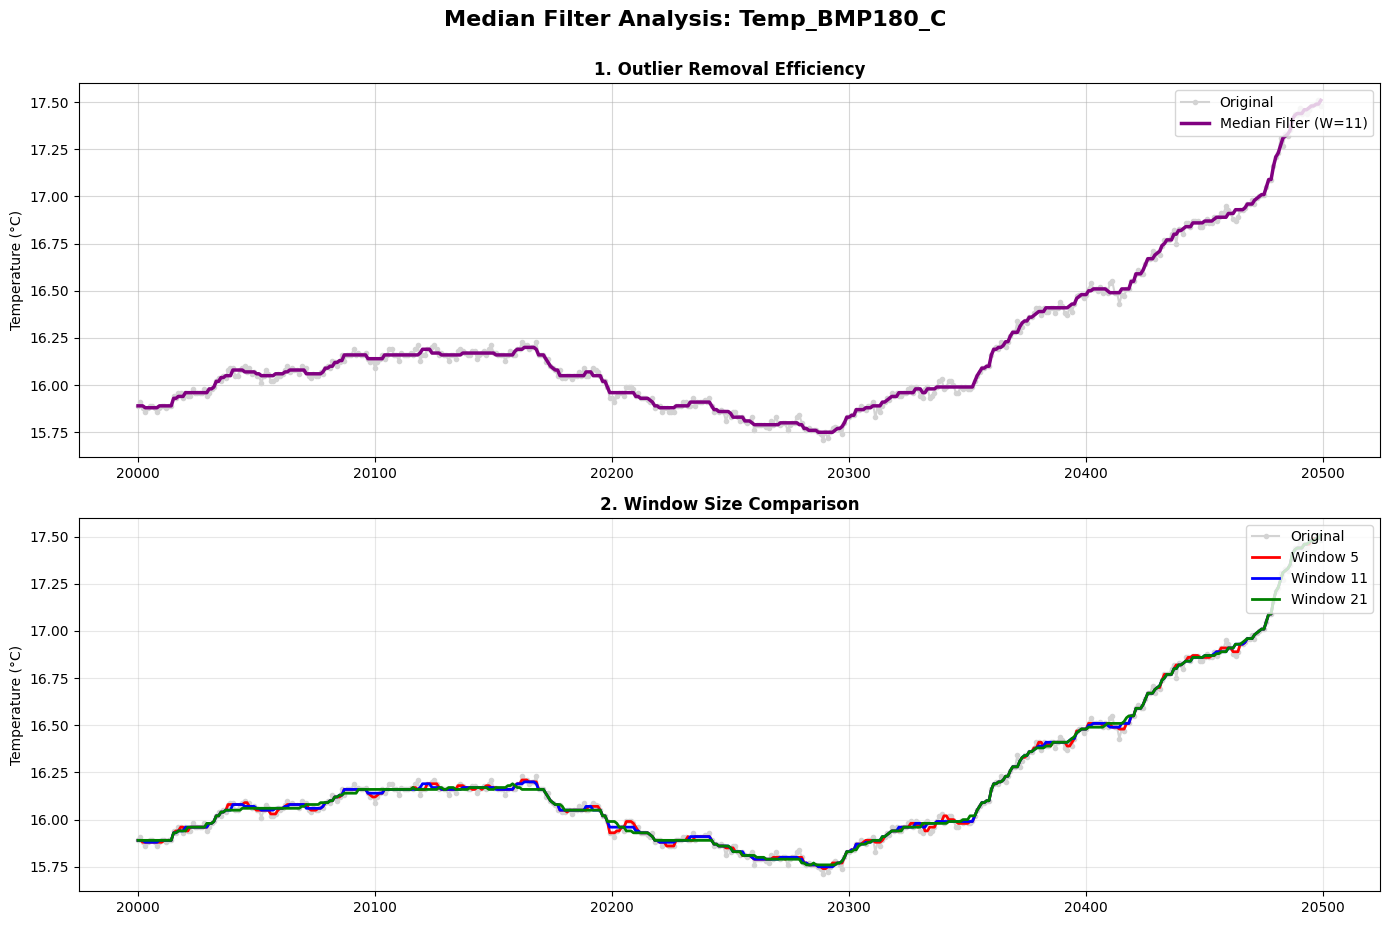

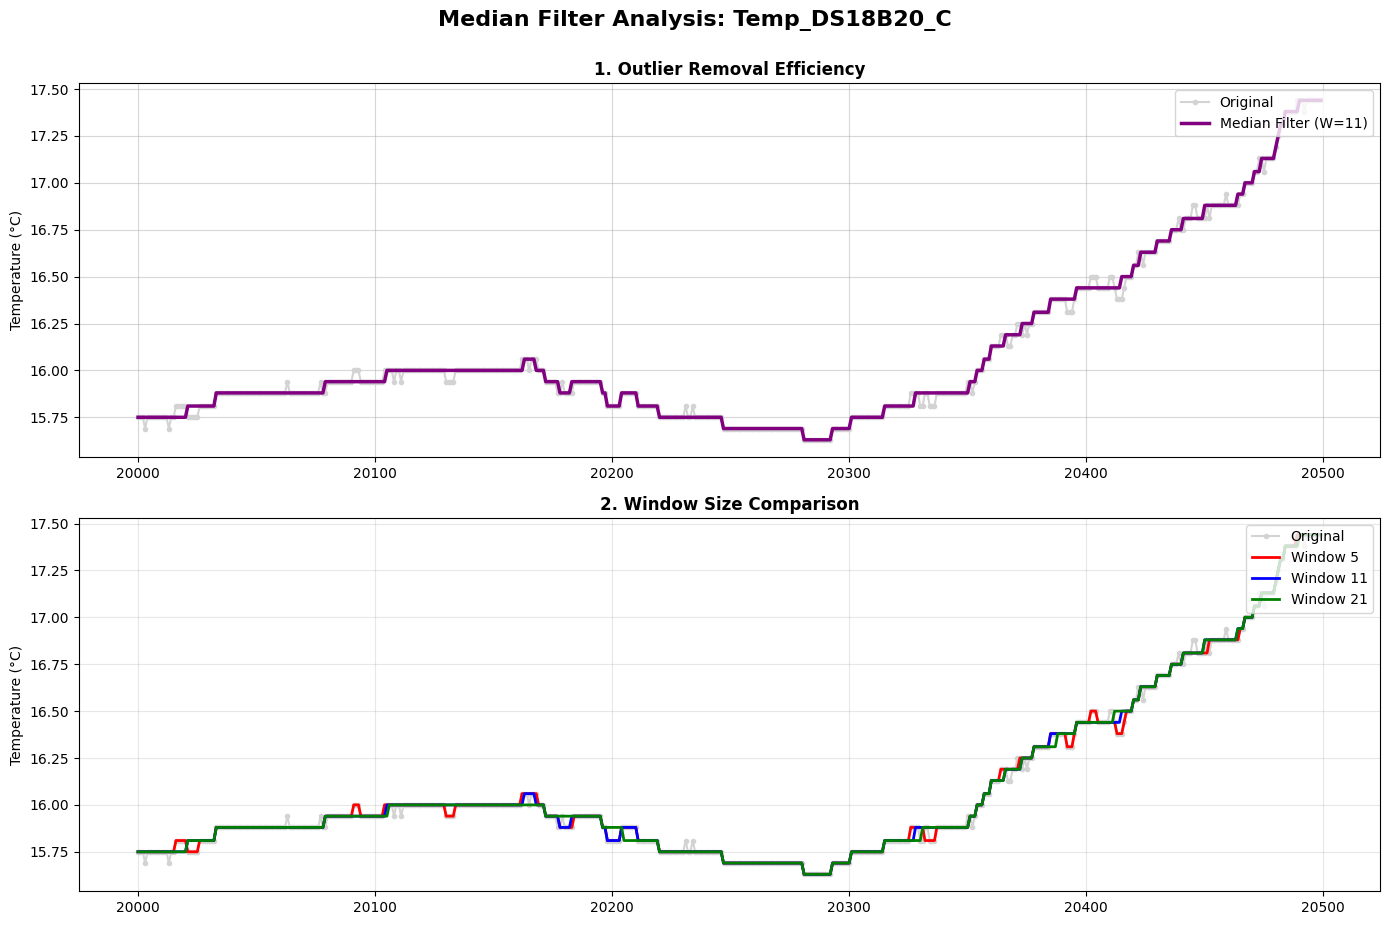

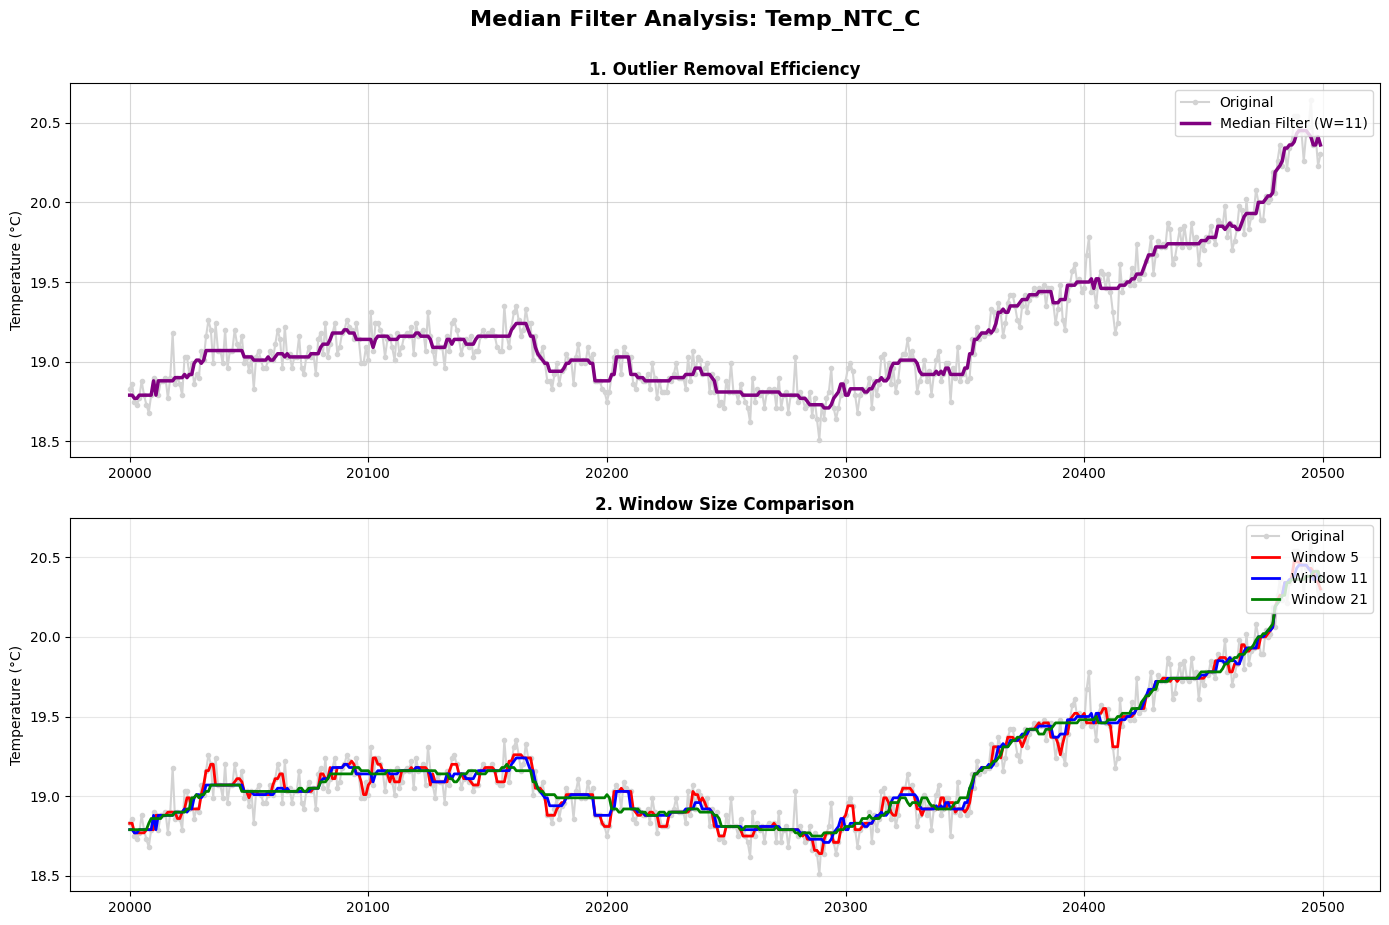

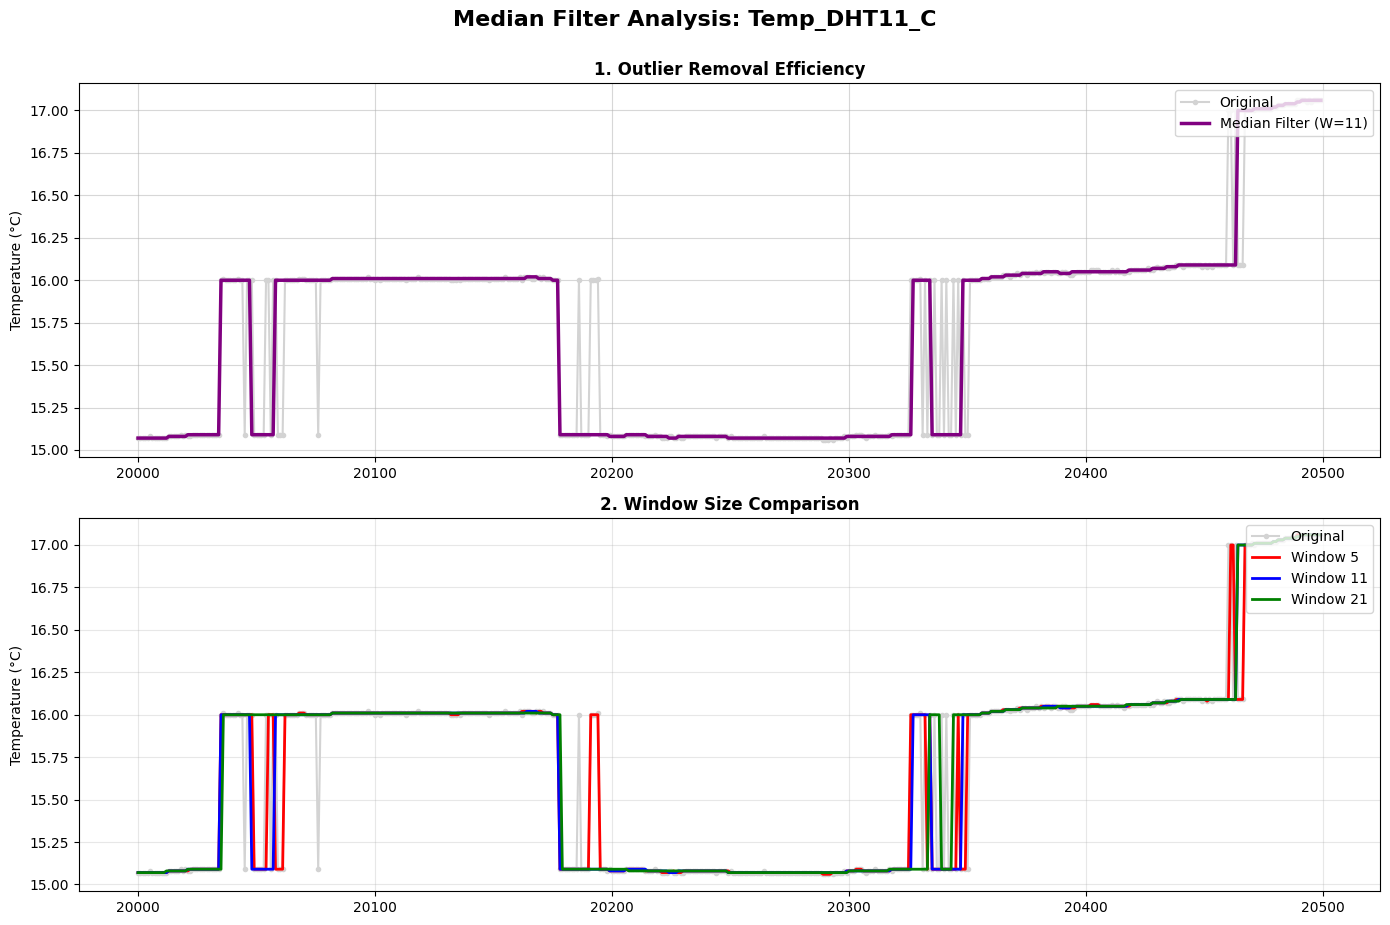

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

temp_sensors = [
    'Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
    'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C' #all sensors
]

test_windows = [5, 11, 21] #median filter window sizes to be evaluated (must be odd numbers)
zoom_start = 20000 #start index for the zoomed view
zoom_end = 20500 #end index for the zoomed view (zoom window being 500 points)
colors = ['red', 'blue', 'green'] #color of each window curve
results = [] #list to store RMSE results

for sensor in temp_sensors: #for all sensors
    result_row = {'Sensor': sensor} #name of each sensor
    original = df[sensor].values
    for w in test_windows: #iterates through all windows
        filtered = medfilt(original, kernel_size=w) #applies median filter with current window size
        #median filter sorts values in window and selects middle value
        #robust to outliers since extreme values don't affect the median position
        mask = ~np.isnan(original) & ~np.isnan(filtered) #mask to exclude NaN values
        rmse = np.sqrt(np.mean((original[mask] - filtered[mask])**2)) # RMSE calculation -> square root of average of (real value - filtered value)^2
        result_row[f'Window {w}'] = rmse #stores RMSE value for the current window
    results.append(result_row) #adds result to results list
df_results = pd.DataFrame(results) #dataframe with results
df_results.set_index('Sensor', inplace=True) #set sensor name as the index
print(df_results) #shows result for each sensor

for sensor in temp_sensors: #for all sensors
    df_zoom = df.iloc[zoom_start:zoom_end].copy() #create a data slice for the zoomed view (20000-20500)
    df_zoom['Median_Filter'] = medfilt(df[sensor].values, kernel_size=11)[zoom_start:zoom_end] #zoom plot comparing original vs median filtered for window of 11
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10)) #plot
    fig.suptitle(f"Median Filter Analysis: {sensor}", fontsize=16, fontweight='bold', y=0.95) #title

    #subplot 1: zoomed view
    ax1.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    ax1.plot(df_zoom.index, df_zoom['Median_Filter'], label='Median Filter (W=11)', color='purple', linewidth=2.5)
    ax1.set_title('1. Outlier Removal Efficiency', fontweight='bold')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.5)
    #subplot 2: comparison of different window sizes
    ax2.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    for i, w in enumerate(test_windows): #for all declared windows
        temp_filter = medfilt(df[sensor].values, kernel_size=w) #applies median filter with current window size
        filter_data_zoom = temp_filter[zoom_start:zoom_end]
        ax2.plot(df_zoom.index, filter_data_zoom, label=f'Window {w}', color=colors[i], linewidth=2) #plots filtered data for each window

    ax2.set_title('2. Window Size Comparison', fontweight='bold')
    ax2.set_ylabel('Temperature (°C)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

The median filter demonstrated superior performance compared to the moving average filter across all temperature sensors, with consistently lower RMSE (e.g., BMP180 with 0.021 vs 0.075 from moving average for equivalent windows), evidencing its effectiveness in removing impulse noise without distorting the signal through arithmetic means that are sensitive to outliers. The performance hierarchy remained identical to the moving average filter (BMP180 best, DHT11 worst), however with significantly lower absolute values, and the pattern of RMSE increase with window size (W5→W11→W21) was smoother and more gradual compared to moving average, indicating that the median filter better preserves signal shape even with larger windows. The DHT11 exhibited distinctive behavior in the graphs with abrupt "step" transitions due to its 1°C resolution combined with the non-linear nature of the median filter that maintains existing discrete values instead of interpolating, while high-resolution sensors (BMP180/BMP280/AHT20) showed uniform smoothing without loss of fidelity to real trends, confirming the median filter's superiority for data with sparse outliers and DHT11's inadequacy for refined analyses.

## 3.2. Humidity

----------------

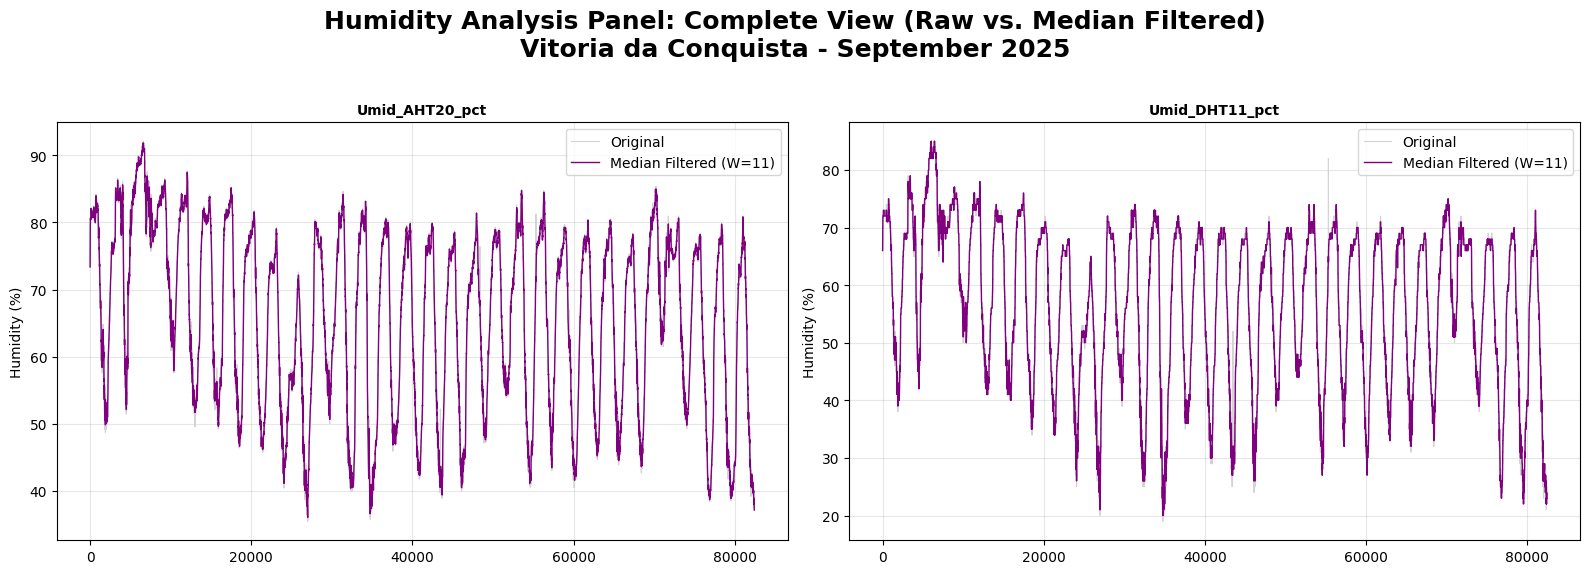

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

humidity_sensors = [
    'Umid_AHT20_pct', 'Umid_DHT11_pct' #humidity sensors
]
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) #Configure the subplot grid (1 row x 2 columns)

axes = axes.flatten()# transforms the subplots into 1d matrix

fig.suptitle("Humidity Analysis Panel: Complete View (Raw vs. Median Filtered)\nVitoria da Conquista - September 2025",
             fontsize=18, fontweight='bold', y=0.98)#title

for i, sensor in enumerate(humidity_sensors):#for all humidity sensors
    ax = axes[i] #traverses the array, plotting one subplot at a time
    median_filter = medfilt(df[sensor].values, kernel_size=11) #median filter calculation considering window of 11
    #the medfilt function applies median filter by sorting values in the window and selecting the middle value
    #kernel_size must be odd number to have a clear center point
    #window of 11 means: takes 5 points before, current point, and 5 points after

    ax.plot(df.index, df[sensor], label='Original', color='lightgray', linewidth=0.8)#plots the original data
    ax.plot(df.index, median_filter, label='Median Filtered (W=11)', color='purple', linewidth=1.0)#plots the median filtered data
    ax.set_title(f'{sensor}', fontweight='bold', fontsize=10) #Subplot title being the sensor name
    ax.set_ylabel('Humidity (%)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

                Window 5  Window 11  Window 21
Sensor                                        
Umid_AHT20_pct  0.212526   0.287781   0.355023
Umid_DHT11_pct  0.327207   0.406503   0.487681


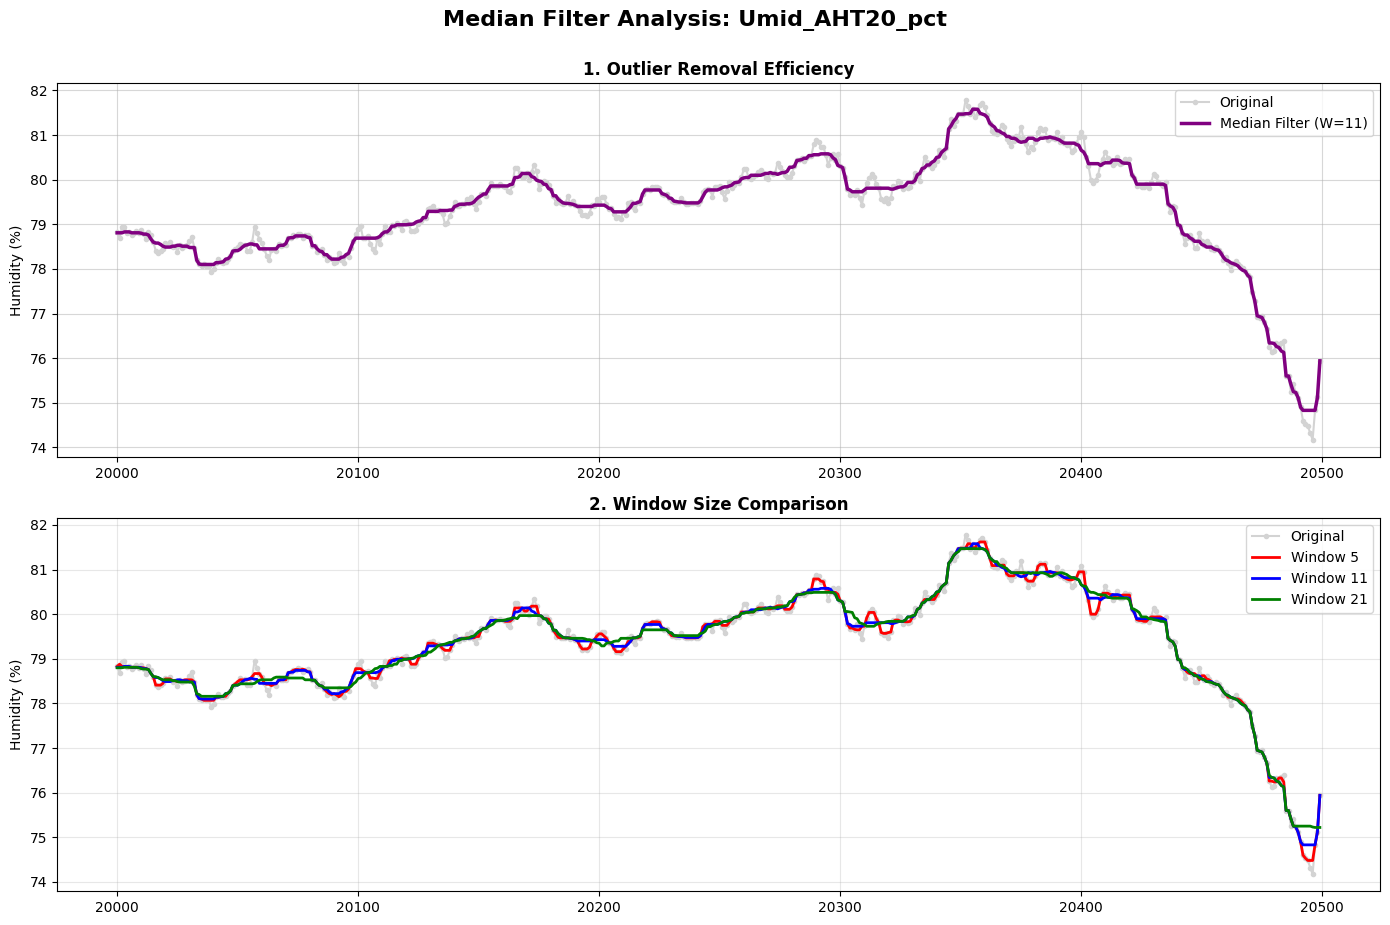

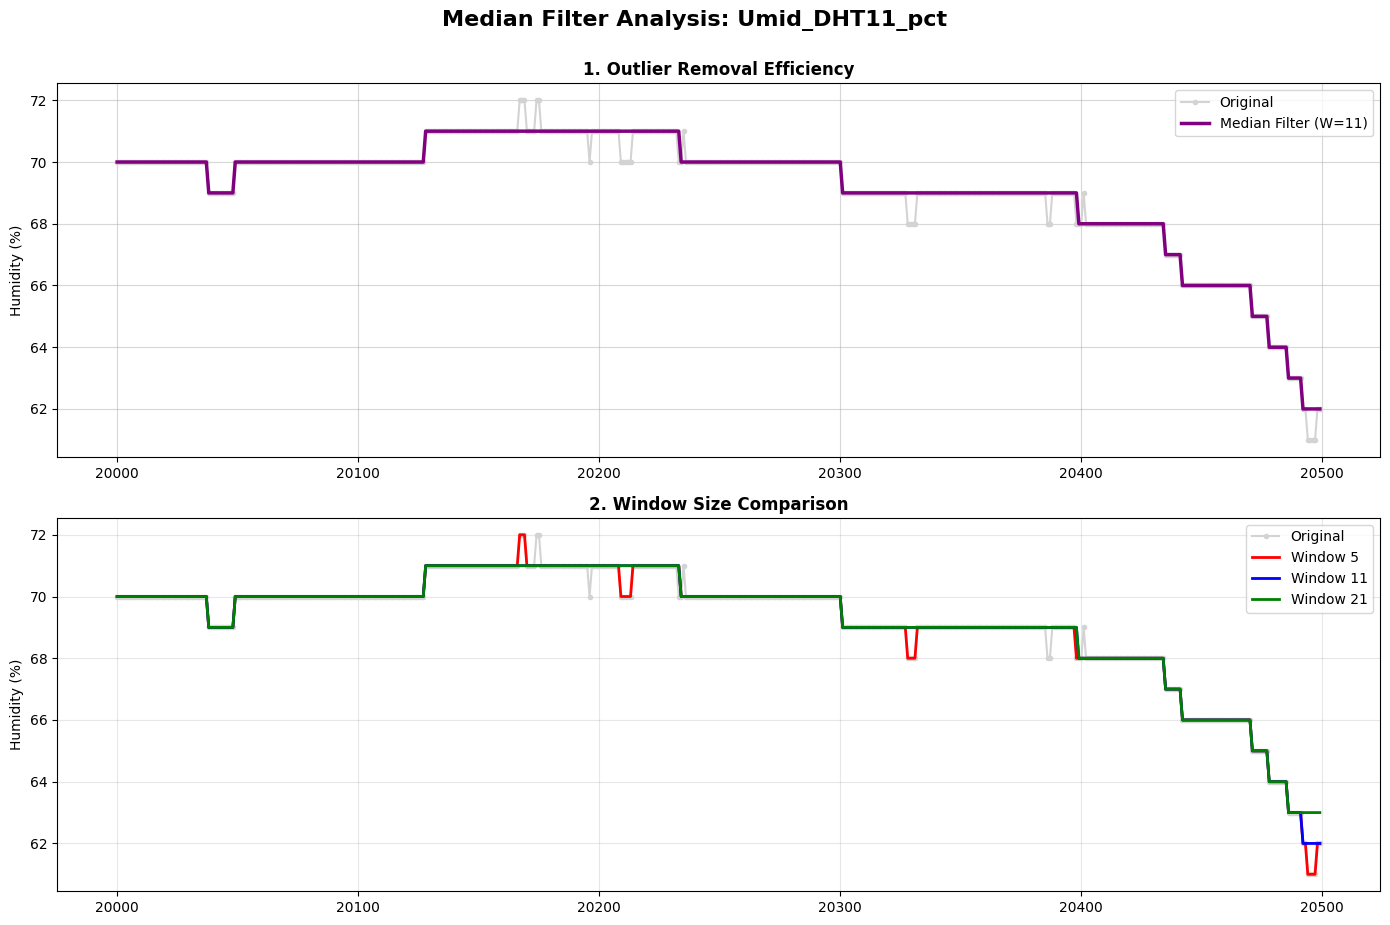

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

humidity_sensors = [
    'Umid_AHT20_pct', 'Umid_DHT11_pct' #all humidity sensors
]

test_windows = [5, 11, 21] #median filter window sizes to be evaluated (must be odd numbers)
zoom_start = 20000 #start index for the zoomed view
zoom_end = 20500 #end index for the zoomed view (zoom window being 500 points)
colors = ['red', 'blue', 'green'] #color of each window curve
results = [] #list to store RMSE results

for sensor in humidity_sensors: #for all sensors
    result_row = {'Sensor': sensor} #name of each sensor
    original = df[sensor].values
    for w in test_windows: #iterates through all windows
        filtered = medfilt(original, kernel_size=w) #applies median filter with current window size
        #median filter sorts values in window and selects middle value
        #robust to outliers since extreme values don't affect the median position
        mask = ~np.isnan(original) & ~np.isnan(filtered) #mask to exclude NaN values
        rmse = np.sqrt(np.mean((original[mask] - filtered[mask])**2)) # RMSE calculation -> square root of average of (real value - filtered value)^2
        result_row[f'Window {w}'] = rmse #stores RMSE value for the current window
    results.append(result_row) #adds result to results list
df_results = pd.DataFrame(results) #dataframe with results
df_results.set_index('Sensor', inplace=True) #set sensor name as the index
print(df_results) #shows result for each sensor

for sensor in humidity_sensors: #for all sensors
    df_zoom = df.iloc[zoom_start:zoom_end].copy() #create a data slice for the zoomed view (20000-20500)
    df_zoom['Median_Filter'] = medfilt(df[sensor].values, kernel_size=11)[zoom_start:zoom_end] #zoom plot comparing original vs median filtered for window of 11
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10)) #plot
    fig.suptitle(f"Median Filter Analysis: {sensor}", fontsize=16, fontweight='bold', y=0.95) #title

    #subplot 1: zoomed view
    ax1.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    ax1.plot(df_zoom.index, df_zoom['Median_Filter'], label='Median Filter (W=11)', color='purple', linewidth=2.5)
    ax1.set_title('1. Outlier Removal Efficiency', fontweight='bold')
    ax1.set_ylabel('Humidity (%)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.5)
    #subplot 2: comparison of different window sizes
    ax2.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    for i, w in enumerate(test_windows): #for all declared windows
        temp_filter = medfilt(df[sensor].values, kernel_size=w) #applies median filter with current window size
        filter_data_zoom = temp_filter[zoom_start:zoom_end]
        ax2.plot(df_zoom.index, filter_data_zoom, label=f'Window {w}', color=colors[i], linewidth=2) #plots filtered data for each window

    ax2.set_title('2. Window Size Comparison', fontweight='bold')
    ax2.set_ylabel('Humidity (%)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

The median filter demonstrated superiority over the moving average filter for humidity, with 53% lower RMSE for AHT20 (0.213 vs 0.449), evidencing effectiveness in removing impulse noise characteristic of abrupt relative humidity fluctuations. The DHT11 exhibited pronounced "step" patterns due to its 1% RH resolution combined with the filter's non-linear nature that maintains discrete values instead of interpolating, while the AHT20 showed uniform smoothing preserving temporal trends. RMSE growth with window size was smoother (aprox 67% from W5→W21) compared to moving average (~100%), confirming that the median filter offers better compromise between outlier removal and temporal dynamics preservation for humidity data.

## 3.3. Pressure

------------

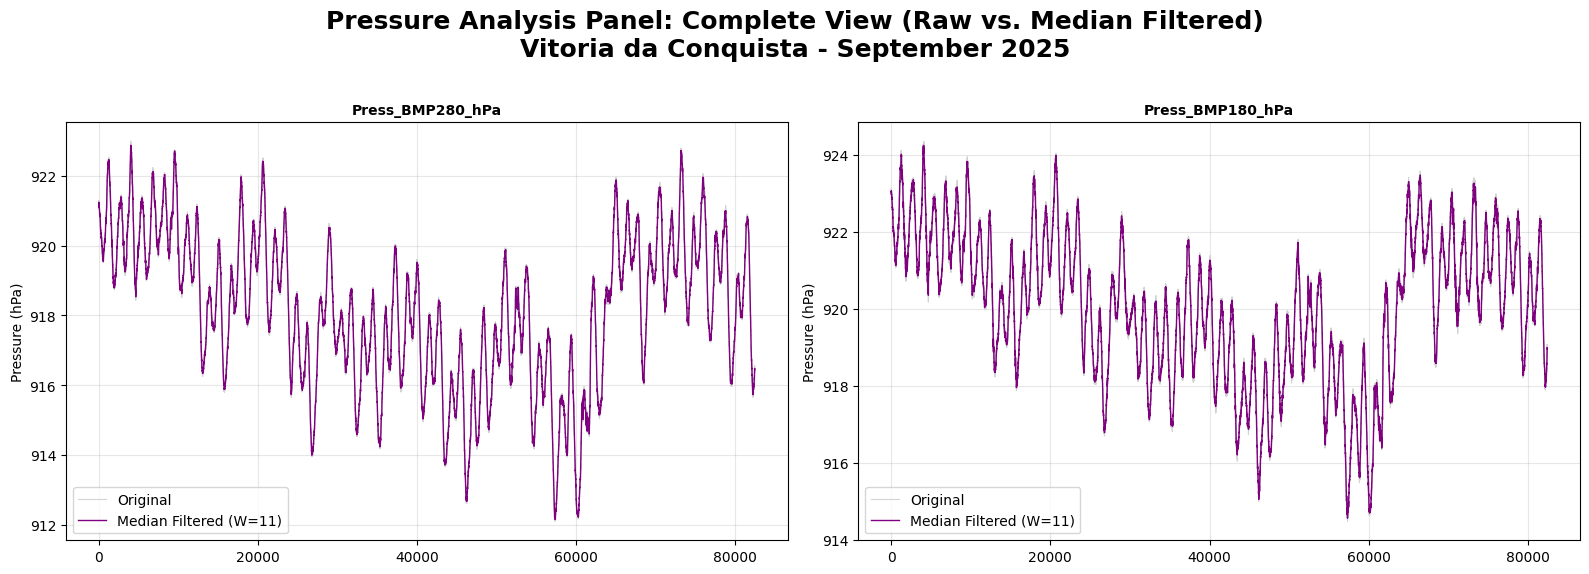

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

pressure_sensors = [
    'Press_BMP280_hPa', 'Press_BMP180_hPa' #pressure sensors
]
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) #Configure the subplot grid (1 row x 2 columns)

axes = axes.flatten()# transforms the subplots into 1d matrix

fig.suptitle("Pressure Analysis Panel: Complete View (Raw vs. Median Filtered)\nVitoria da Conquista - September 2025",
             fontsize=18, fontweight='bold', y=0.98)#title

for i, sensor in enumerate(pressure_sensors):#for all pressure sensors
    ax = axes[i] #traverses the array, plotting one subplot at a time
    median_filter = medfilt(df[sensor].values, kernel_size=11) #median filter calculation considering window of 11
    #the medfilt function applies median filter by sorting values in the window and selecting the middle value
    #kernel_size must be odd number to have a clear center point
    #window of 11 means: takes 5 points before, current point, and 5 points after

    ax.plot(df.index, df[sensor], label='Original', color='lightgray', linewidth=0.8)#plots the original data
    ax.plot(df.index, median_filter, label='Median Filtered (W=11)', color='purple', linewidth=1.0)#plots the median filtered data
    ax.set_title(f'{sensor}', fontweight='bold', fontsize=10) #Subplot title being the sensor name
    ax.set_ylabel('Pressure (hPa)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

                  Window 5  Window 11  Window 21
Sensor                                          
Press_BMP280_hPa  0.036557   0.039031   0.040949
Press_BMP180_hPa  0.047222   0.051623   0.055604


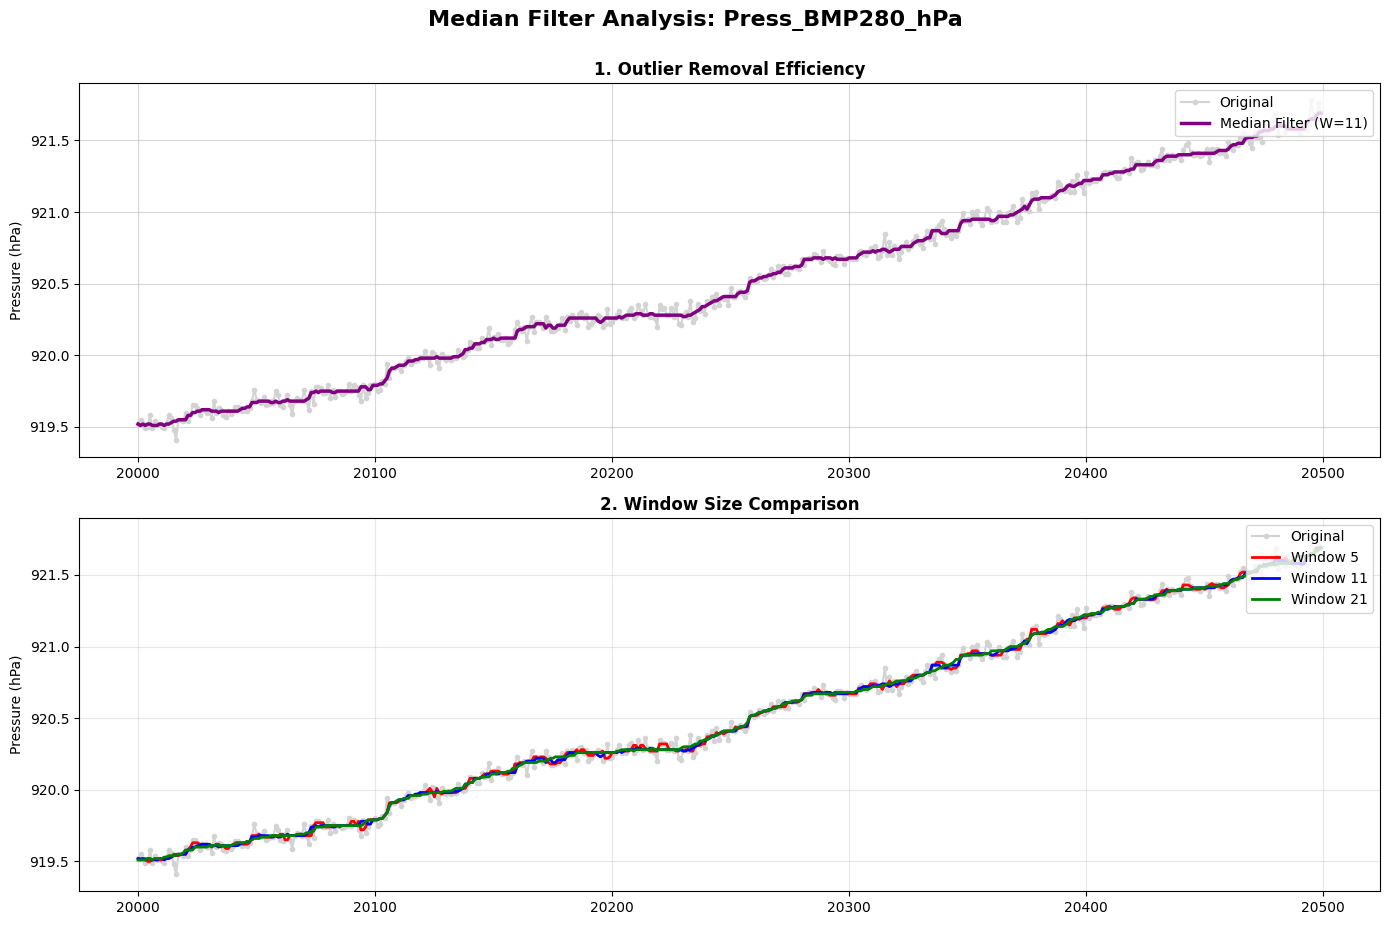

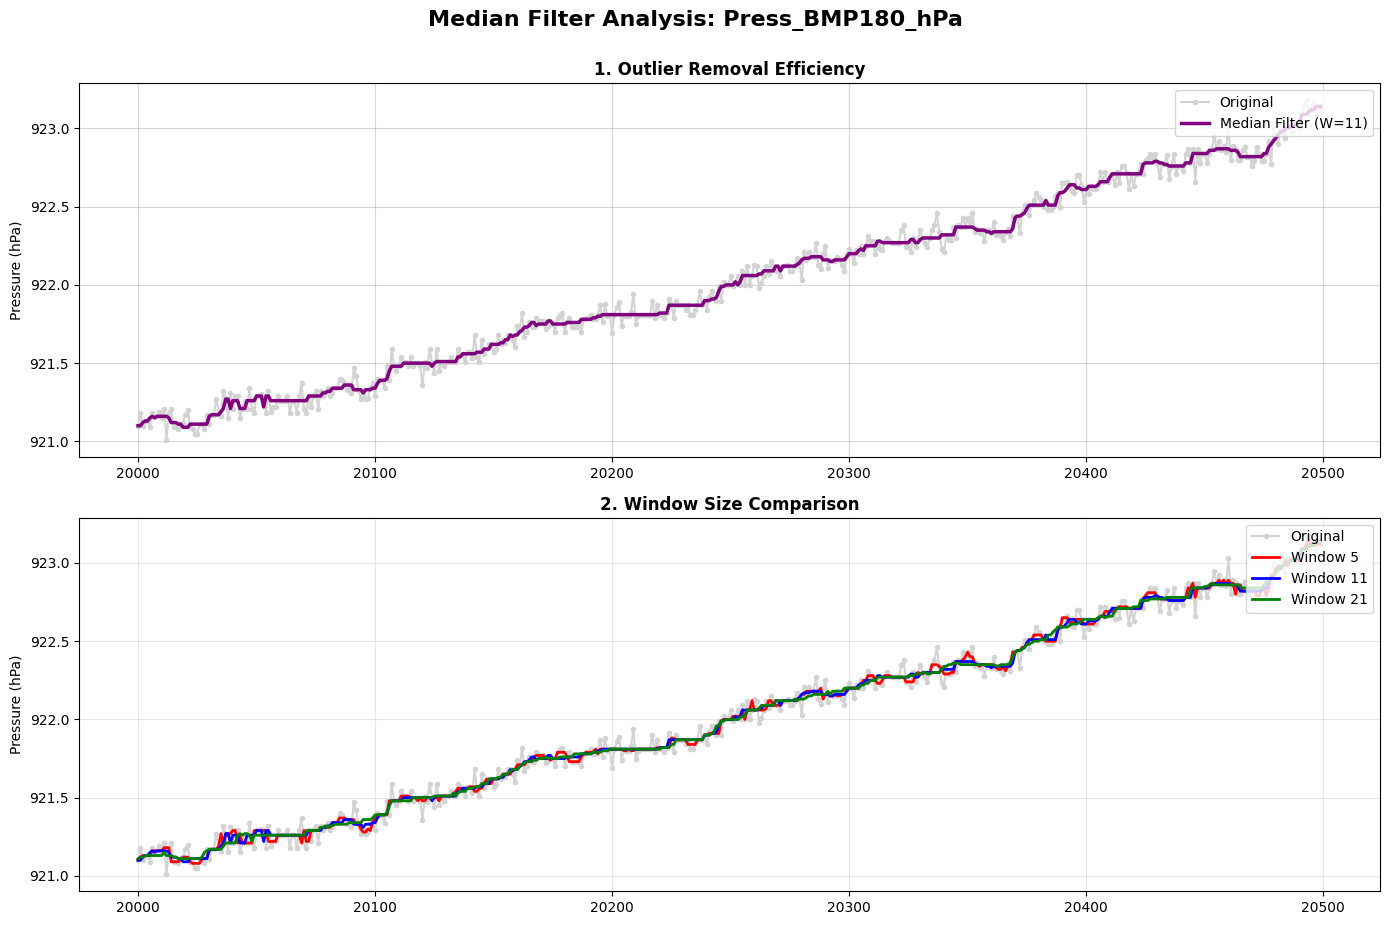

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

pressure_sensors = [
    'Press_BMP280_hPa', 'Press_BMP180_hPa' #all pressure sensors
]

test_windows = [5, 11, 21] #median filter window sizes to be evaluated (must be odd numbers)
zoom_start = 20000 #start index for the zoomed view
zoom_end = 20500 #end index for the zoomed view (zoom window being 500 points)
colors = ['red', 'blue', 'green'] #color of each window curve
results = [] #list to store RMSE results

for sensor in pressure_sensors: #for all sensors
    result_row = {'Sensor': sensor} #name of each sensor
    original = df[sensor].values
    for w in test_windows: #iterates through all windows
        filtered = medfilt(original, kernel_size=w) #applies median filter with current window size
        #median filter sorts values in window and selects middle value
        #robust to outliers since extreme values don't affect the median position
        mask = ~np.isnan(original) & ~np.isnan(filtered) #mask to exclude NaN values
        rmse = np.sqrt(np.mean((original[mask] - filtered[mask])**2)) # RMSE calculation -> square root of average of (real value - filtered value)^2
        result_row[f'Window {w}'] = rmse #stores RMSE value for the current window
    results.append(result_row) #adds result to results list
df_results = pd.DataFrame(results) #dataframe with results
df_results.set_index('Sensor', inplace=True) #set sensor name as the index
print(df_results) #shows result for each sensor

for sensor in pressure_sensors: #for all sensors
    df_zoom = df.iloc[zoom_start:zoom_end].copy() #create a data slice for the zoomed view (20000-20500)
    df_zoom['Median_Filter'] = medfilt(df[sensor].values, kernel_size=11)[zoom_start:zoom_end] #zoom plot comparing original vs median filtered for window of 11
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10)) #plot
    fig.suptitle(f"Median Filter Analysis: {sensor}", fontsize=16, fontweight='bold', y=0.95) #title

    #subplot 1: zoomed view
    ax1.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    ax1.plot(df_zoom.index, df_zoom['Median_Filter'], label='Median Filter (W=11)', color='purple', linewidth=2.5)
    ax1.set_title('1. Outlier Removal Efficiency', fontweight='bold')
    ax1.set_ylabel('Pressure (hPa)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.5)
    #subplot 2: comparison of different window sizes
    ax2.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    for i, w in enumerate(test_windows): #for all declared windows
        temp_filter = medfilt(df[sensor].values, kernel_size=w) #applies median filter with current window size
        filter_data_zoom = temp_filter[zoom_start:zoom_end]
        ax2.plot(df_zoom.index, filter_data_zoom, label=f'Window {w}', color=colors[i], linewidth=2) #plots filtered data for each window

    ax2.set_title('2. Window Size Comparison', fontweight='bold')
    ax2.set_ylabel('Pressure (hPa)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

The median filter applied to barometric sensors demonstrated exceptional performance with extremely low RMSE albeit slightly higher than the moving average filter (BMP280: 0.037 vs 0.049 from moving average, though the difference for pressure is minimal), evidencing that for signals with slow variation and naturally low noise like atmospheric pressure, both filters converge to similar effectiveness. The graphs reveal near-perfect convergence among all windows (W5, W11, W21) due to the monotonic and smooth nature of barometric variations, where outliers are extremely rare and the signal is dominated by synoptic-scale long-term trends, making the median filter's advantage in rejecting outliers less relevant in this context. The minimal RMSE growth pattern with window size (~12% from W5→W21 vs ~67% in humidity) confirms that atmospheric pressure tolerates any filter configuration well, and the choice between moving average or median for barometric data can be guided more by computational efficiency (moving average faster) than by significant performance differences.

## 3.4. Root Mean Square Error (RMSE) Analysis

---------------

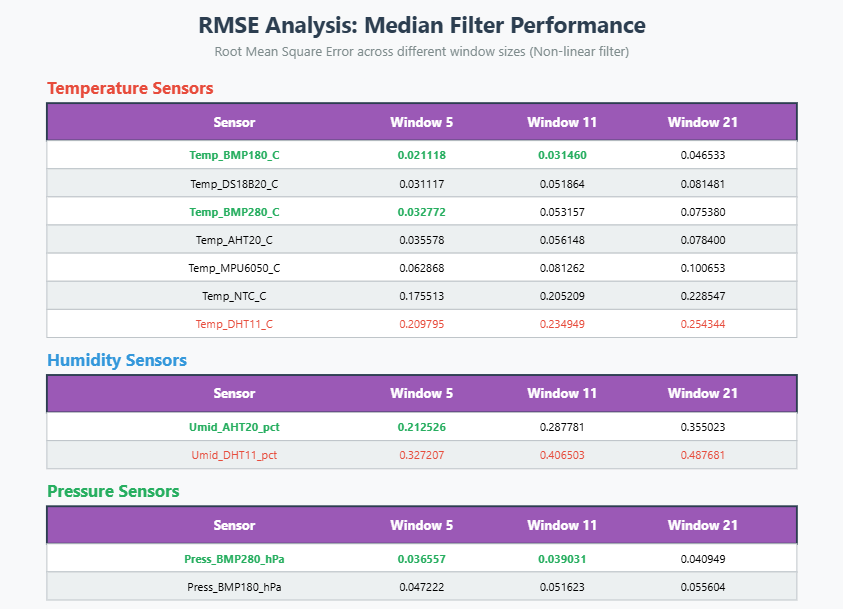

Comparative RMSE analysis of the median filter revealed consistent superiority over the moving average filter in temperature (BMP180: 0.021 vs 0.075) and humidity (AHT20: 0.213 vs 0.449), with reductions up to 72% and 53% respectively, while in atmospheric pressure both filters showed equivalent performance (BMP280: 0.037 median vs 0.049 moving average, only 25% difference) due to the smooth and outlier-free nature of barometric data. The RMSE growth pattern with window size was more gradual in the median filter (temperature: 140% from W5→W21, humidity: 67%) compared to moving average (temperature: 200-300%, humidity: 100%), confirming better signal shape preservation even with larger windows thanks to median robustness against extreme values. The performance hierarchy among sensors remained identical in both filters (BMP180/BMP280 best, DHT11 worst), however with significantly lower absolute values in the median filter, validating its recommendation as the preferred filter for data with sparse outliers in temperature and humidity, while for atmospheric pressure the choice can be guided by computational efficiency favoring the moving average.

# 4.Exponential Moving Average Analysis

----

## 4.1. Temperature

------------

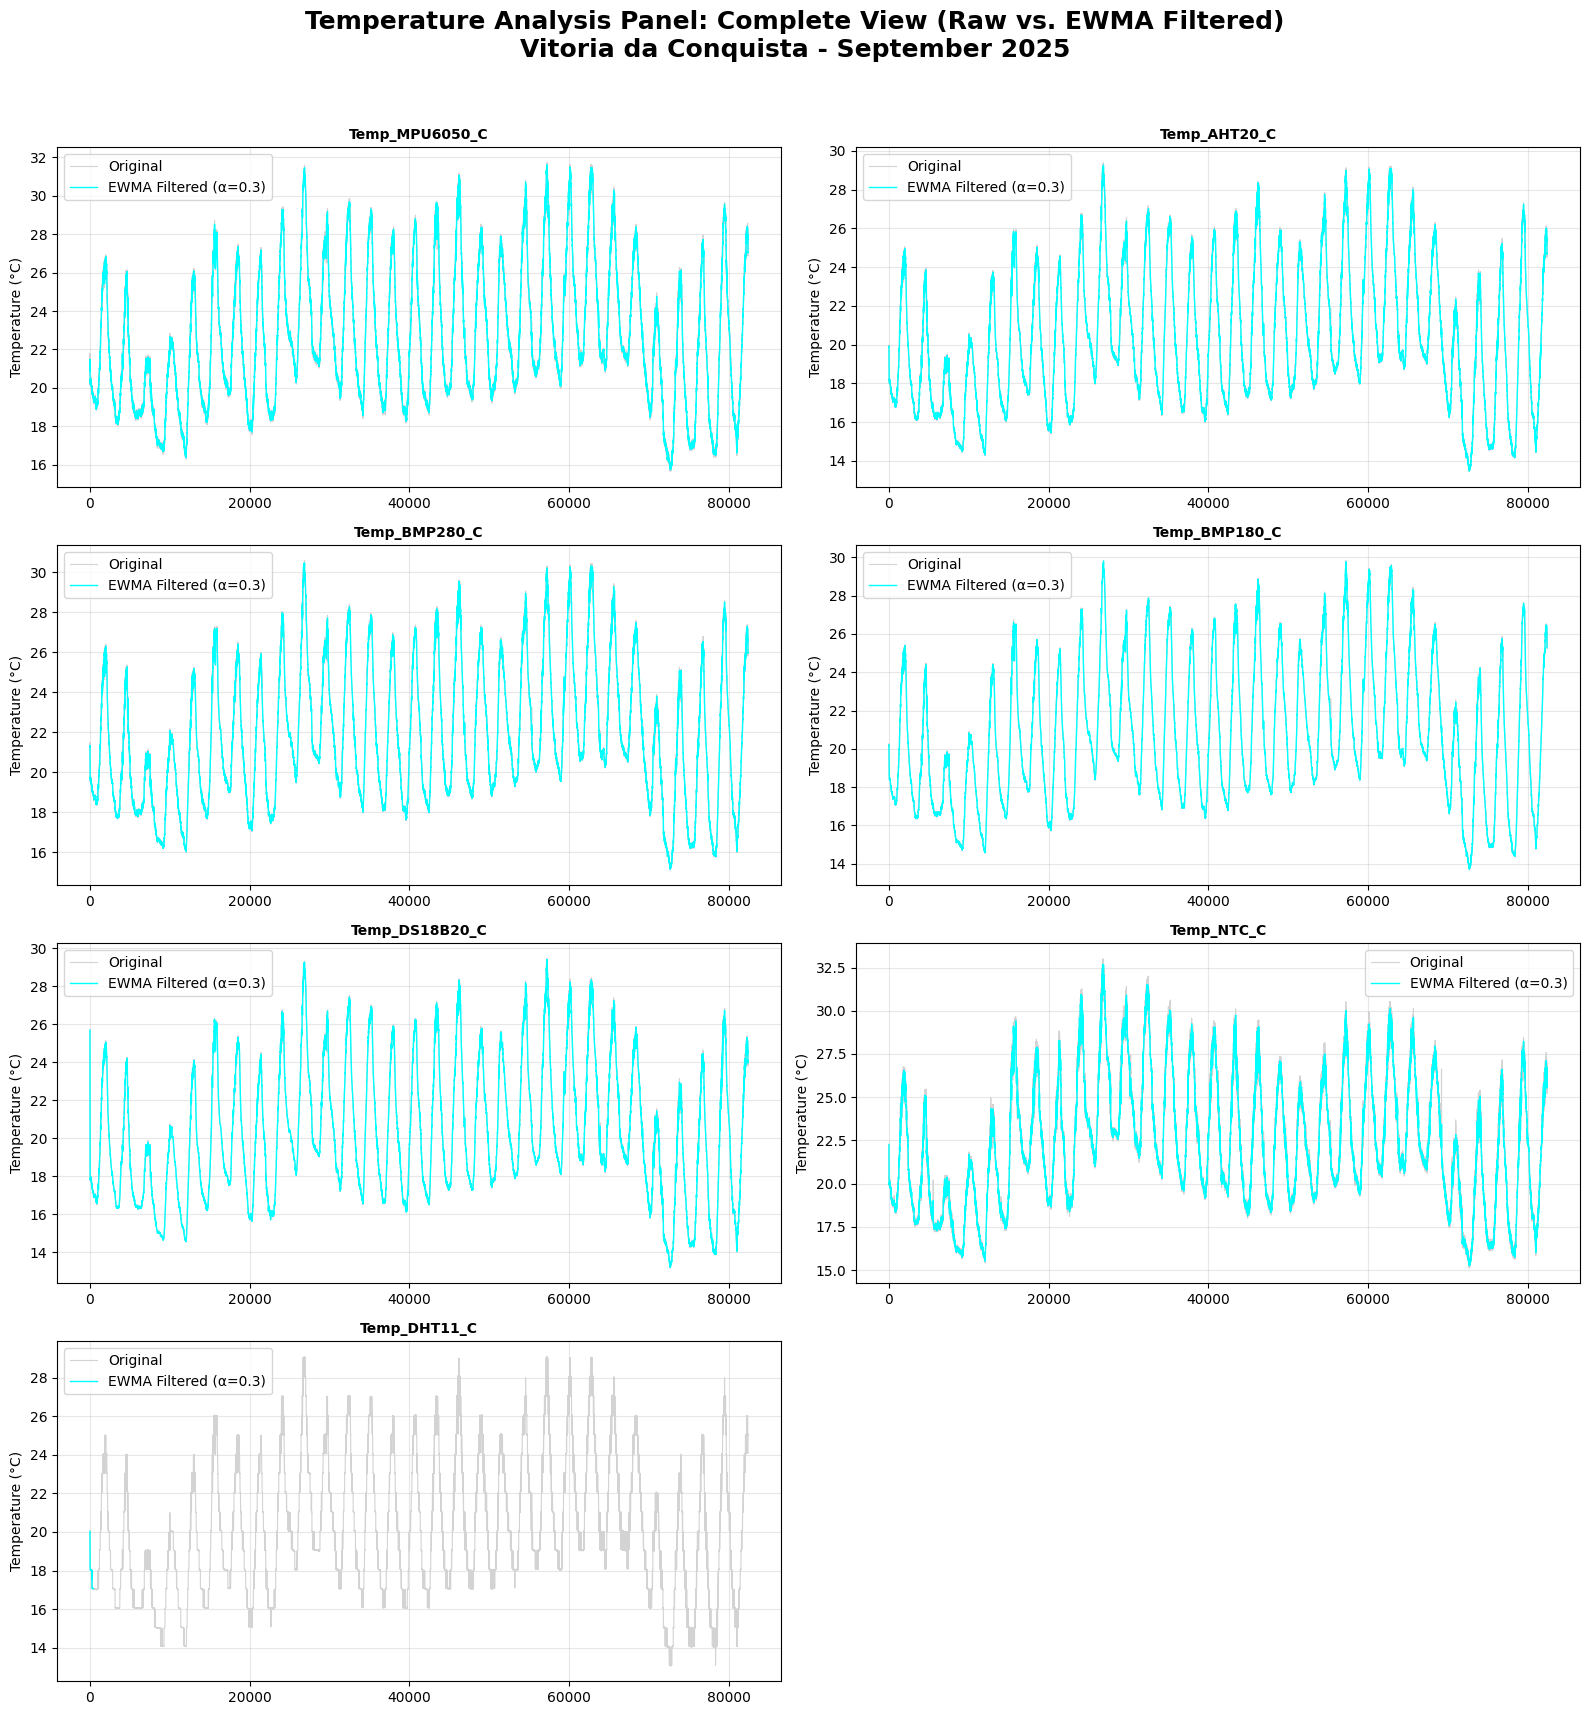

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def ewma_filter(data, alpha=0.3): #Exponential filter, where alpha is the smoothing factor (between 0 and 1), the closer to 1 the less smoothing
    filtered = np.zeros_like(data, dtype=float) #filtered vector with same size as data filled with 0
    filtered[0] = data[0] # the first filtered value receives exactly the first value of the signal, so it is copied
    for i in range(1, len(data)): #from the second element to the end
        filtered[i] = alpha * data[i] + (1 - alpha) * filtered[i-1] #exponential filter formula
    return filtered
temp_sensors = [
    'Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
    'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C' #temperature sensors
]
fig, axes = plt.subplots(4, 2, figsize=(16, 18)) #Configure the subplot grid (4 rows x 2 columns)
#[[ax00, ax01],
# [ax10, ax11],
# [ax20, ax21],
# [ax30, ax31]]
axes = axes.flatten()# transforms the subplots into 1d matrix [ax00, ax01, ax10, ax11, ax20, ax21, ax30, ax31]
fig.suptitle("Temperature Analysis Panel: Complete View (Raw vs. EWMA Filtered)\nVitoria da Conquista - September 2025",
             fontsize=18, fontweight='bold', y=0.98)#title
for i, sensor in enumerate(temp_sensors):#for all temperature sensors
    ax = axes[i] #traverses the array, plotting one subplot at a time
    ewma_filtered = ewma_filter(df[sensor].values, alpha=0.3) #EWMA filter calculation with alpha of 0.3
    #the EWMA filter gives exponentially decreasing weights to older observations
    #alpha controls smoothing: higher alpha = more weight on recent data (less smoothing)
    #lower alpha = more weight on past data (more smoothing)

    ax.plot(df.index, df[sensor], label='Original', color='lightgray', linewidth=0.8)#plots the original data
    ax.plot(df.index, ewma_filtered, label='EWMA Filtered (α=0.3)', color='cyan', linewidth=1.0)#plots the EWMA filtered data
    ax.set_title(f'{sensor}', fontweight='bold', fontsize=10) #Subplot title being the sensor name
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

fig.delaxes(axes[7]) #removes the empty graph left over (there are 8 so the last one will be left over, since there are 7 sensors)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

                Alpha 0.1  Alpha 0.3  Alpha 0.5
Sensor                                         
Temp_MPU6050_C   0.140944   0.076376   0.049213
Temp_AHT20_C     0.124473   0.060700   0.036134
Temp_BMP280_C    0.120800   0.058393   0.034475
Temp_BMP180_C    0.105251   0.042201   0.023465
Temp_DS18B20_C   0.127423   0.058097   0.032998
Temp_NTC_C       0.242373   0.166408   0.117486
Temp_DHT11_C     0.200172   0.103078   0.069587


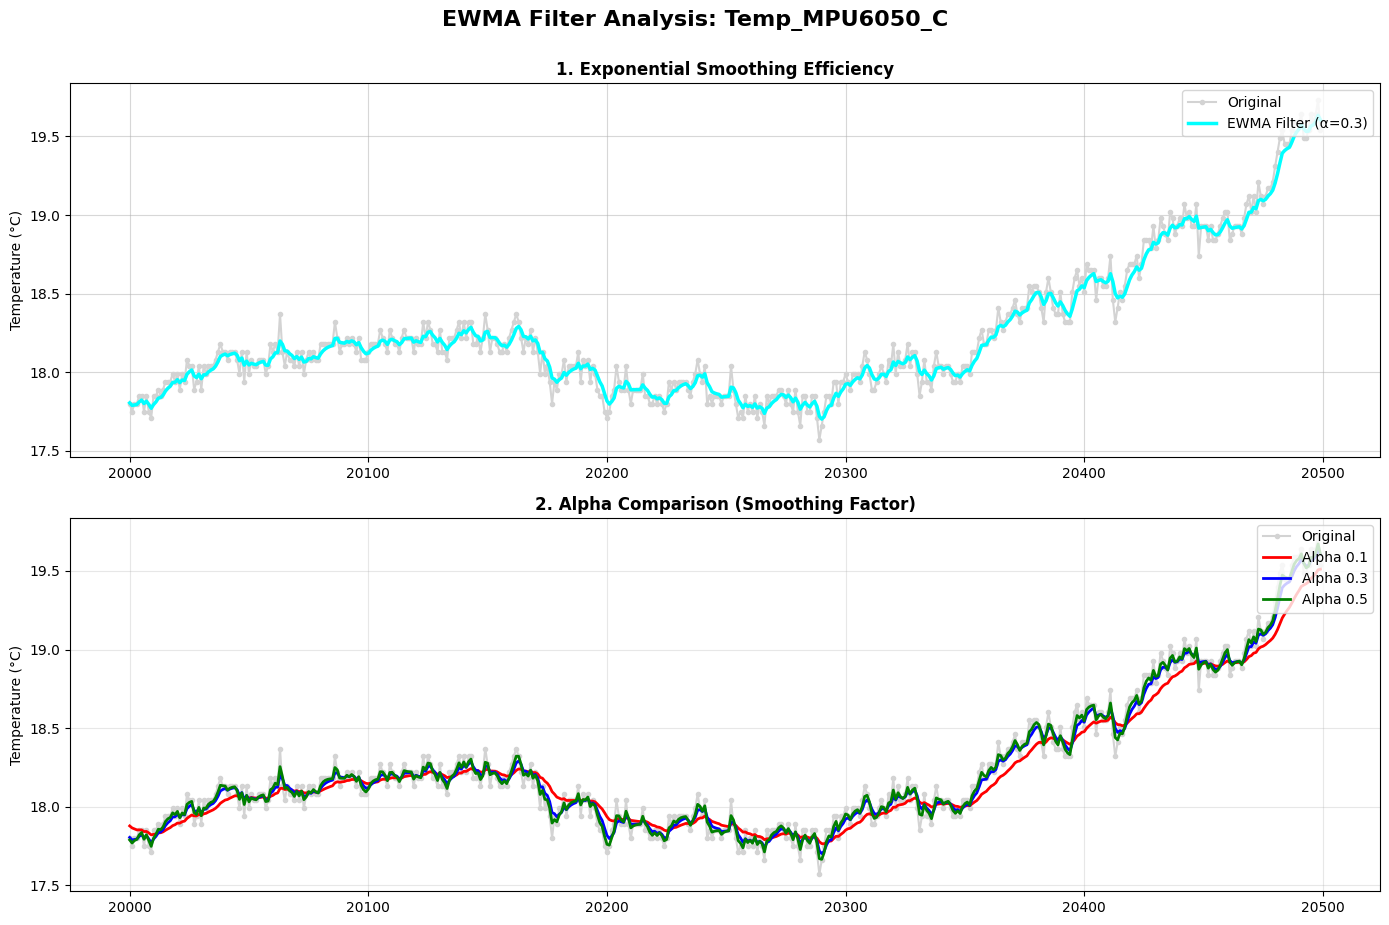

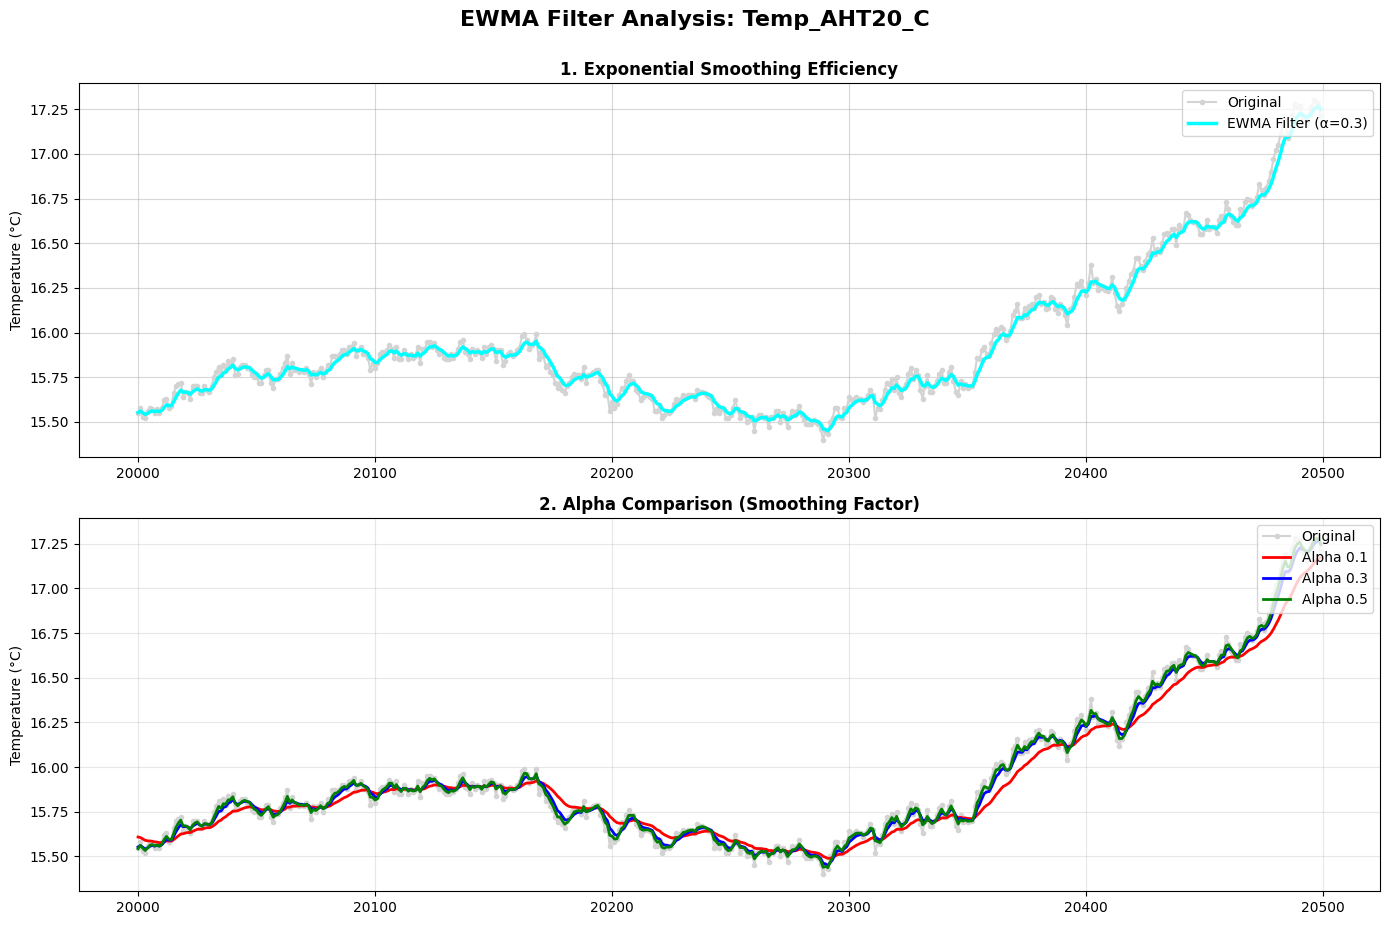

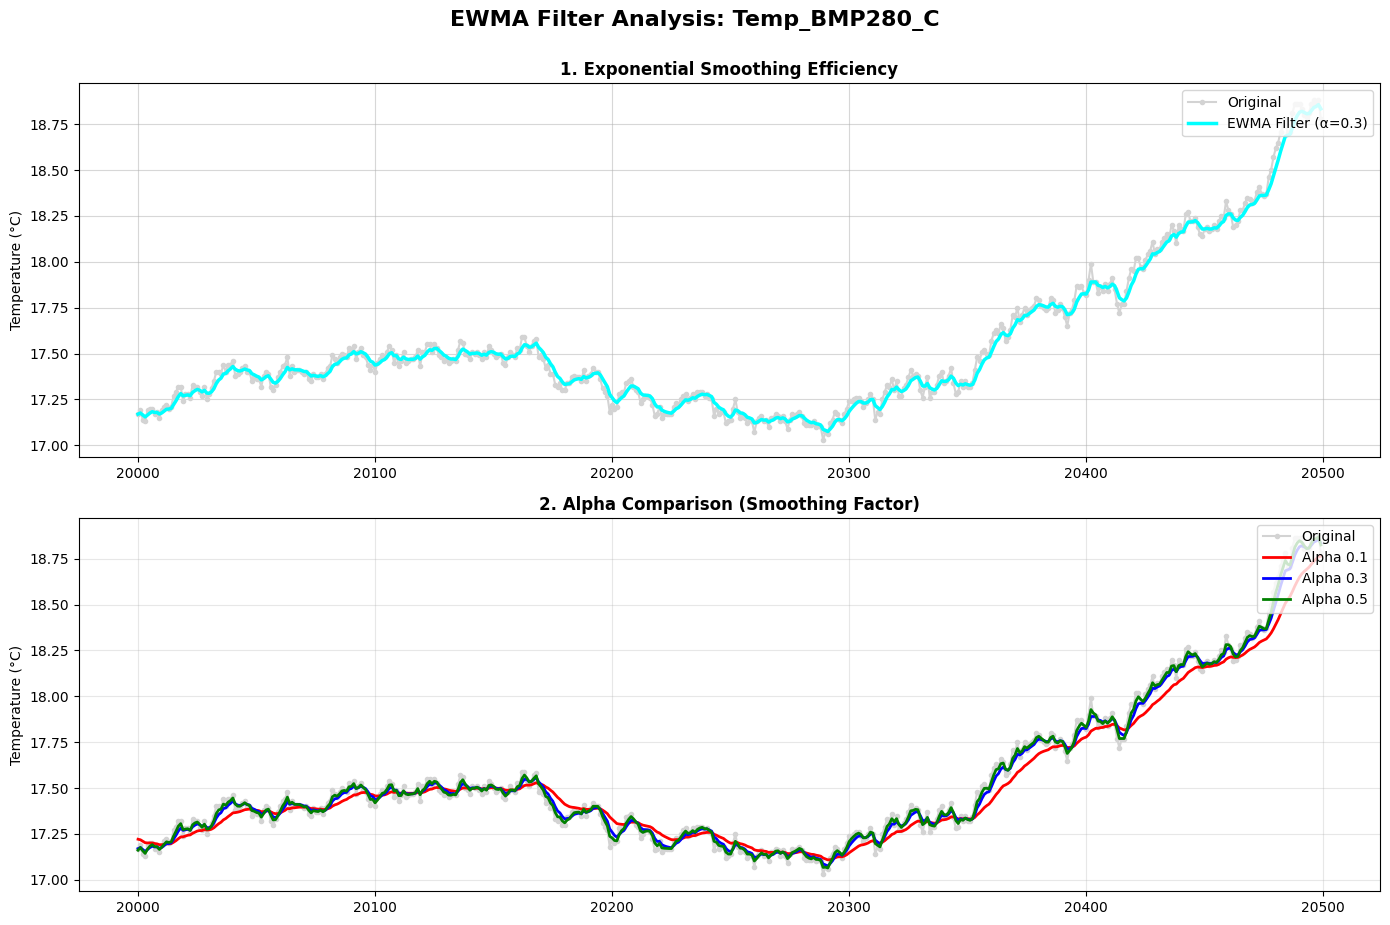

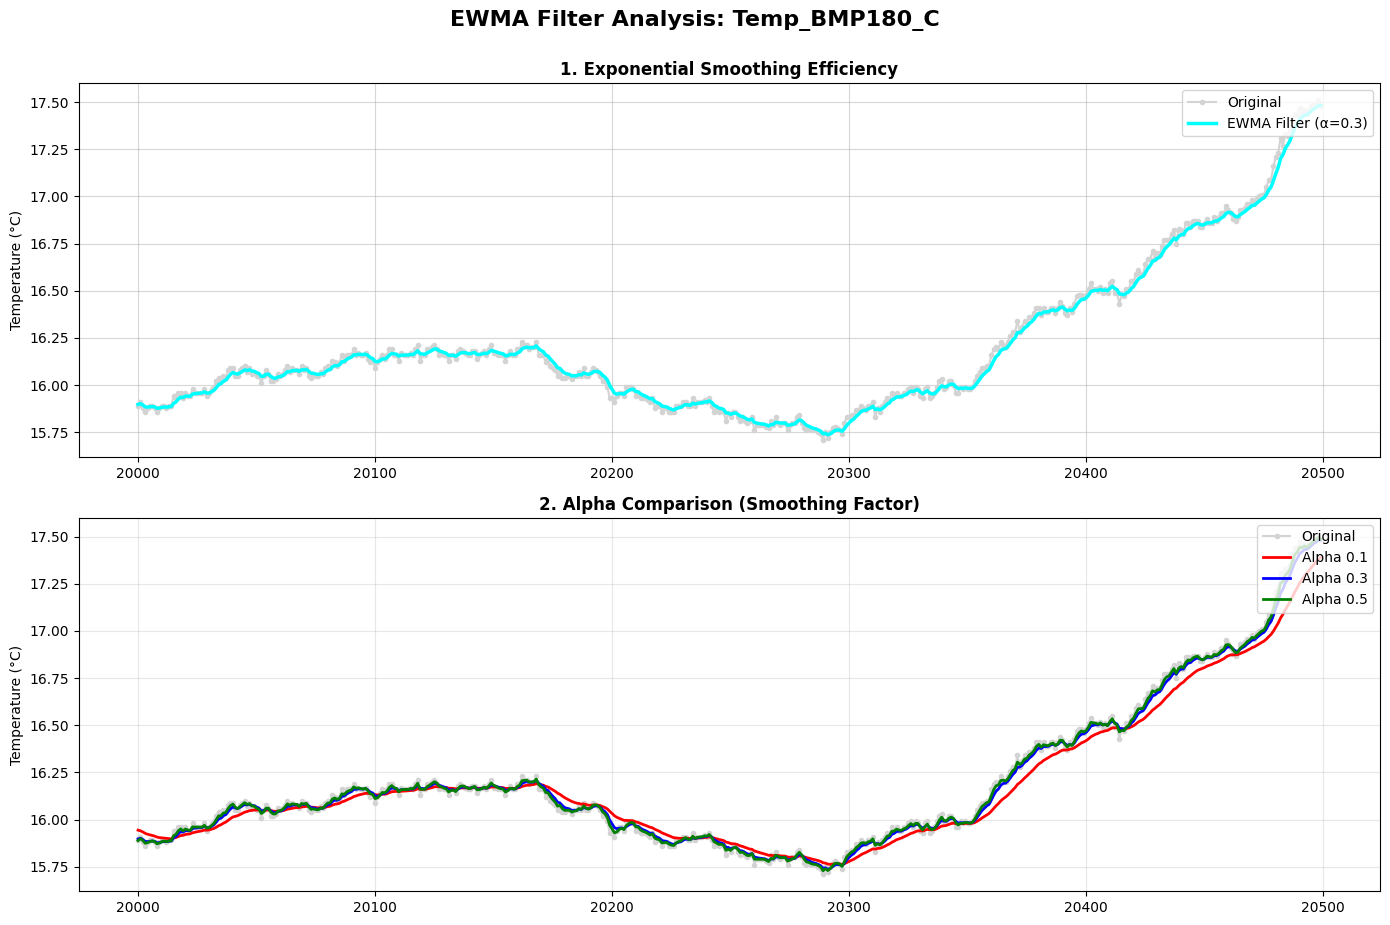

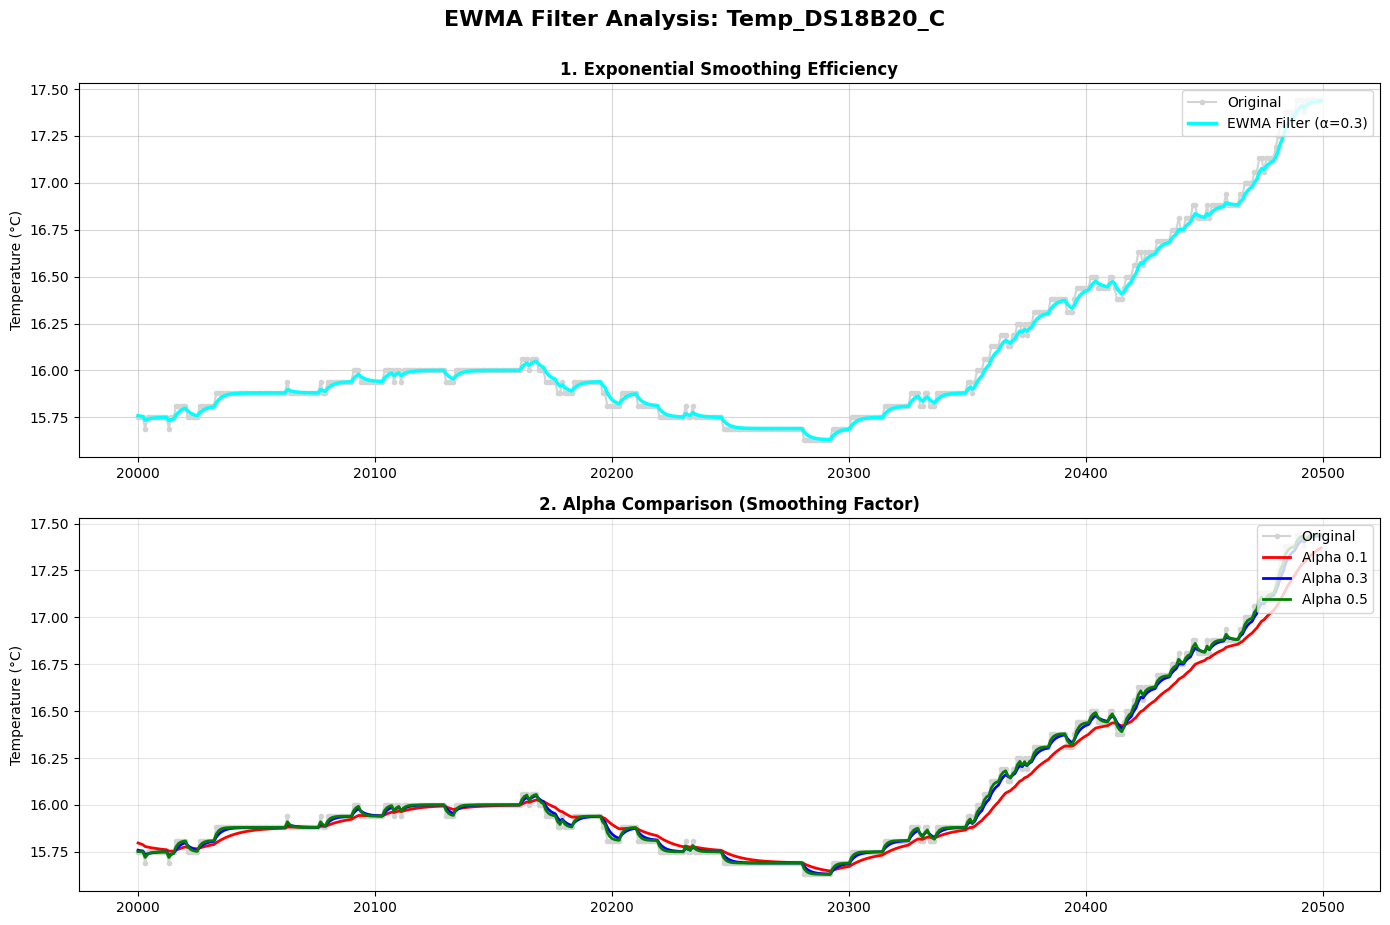

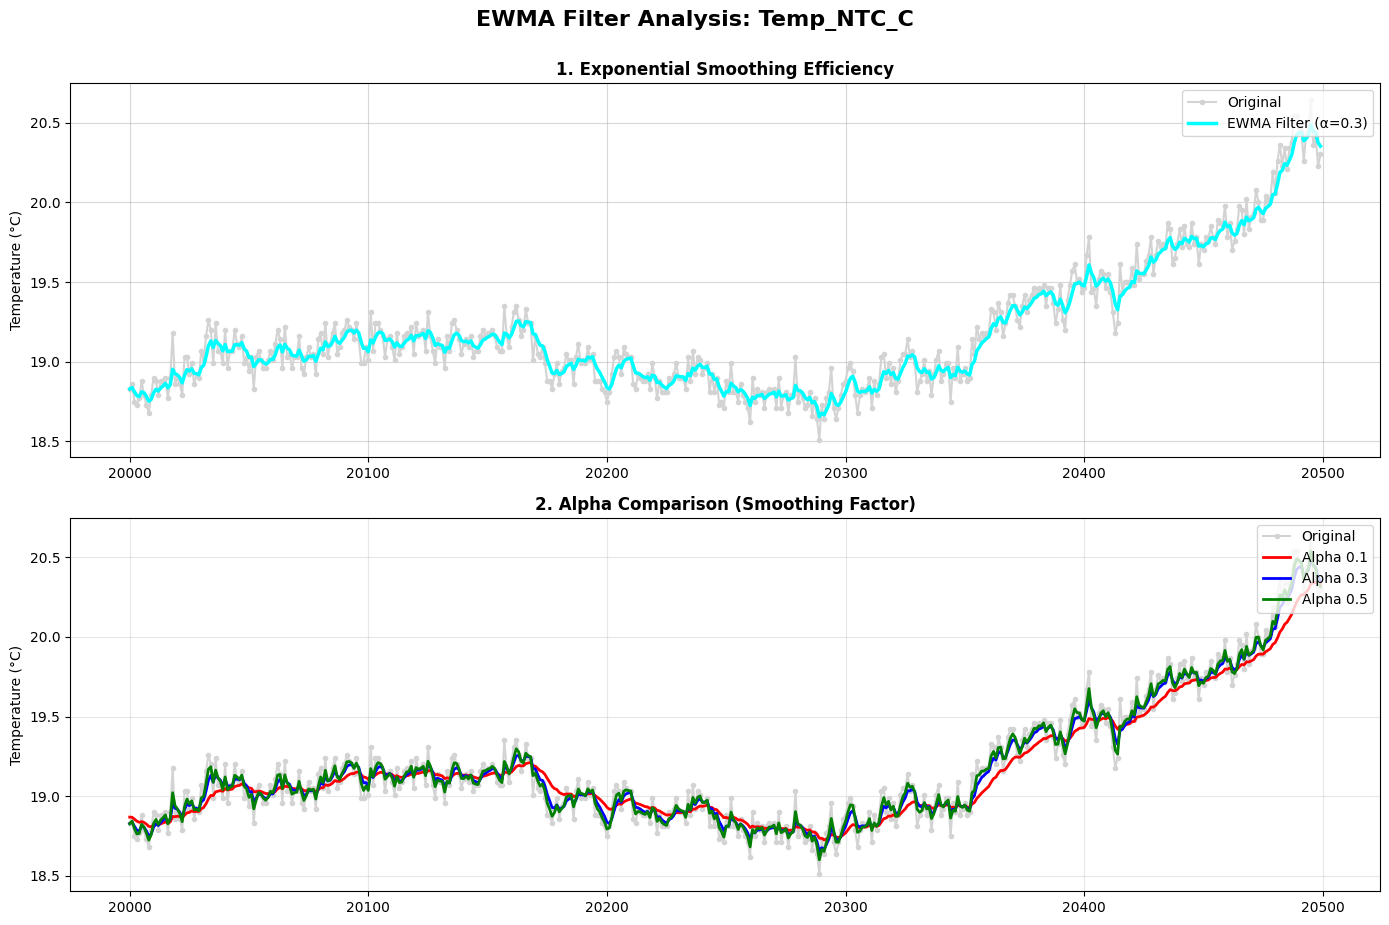

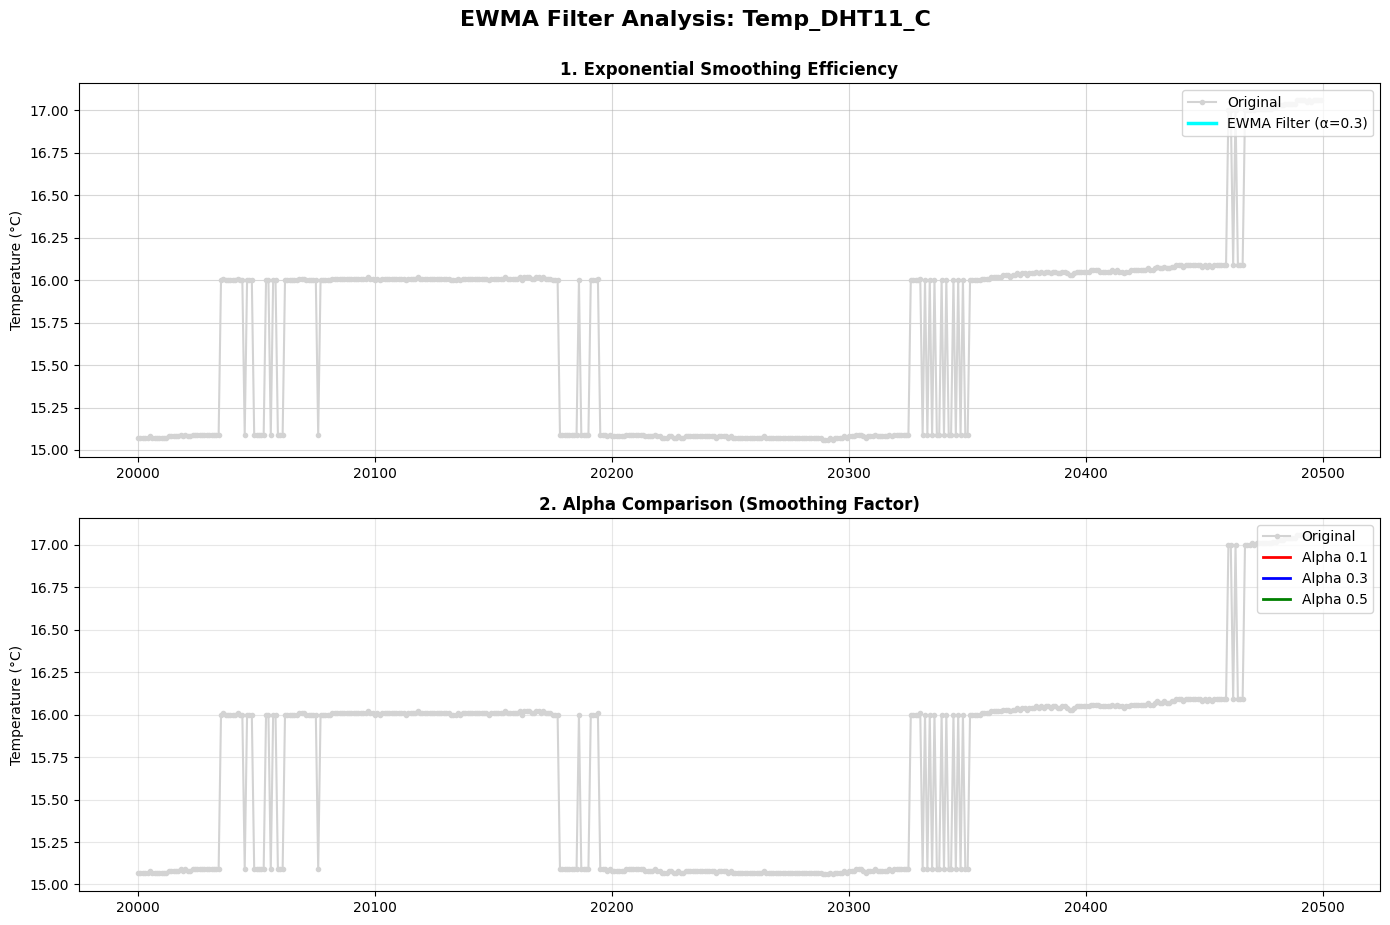

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def ewma_filter(data, alpha=0.3): #Exponential filter, where alpha is the smoothing factor (between 0 and 1), the closer to 1 the less smoothing
    filtered = np.zeros_like(data, dtype=float) #filtered vector with same size as data filled with 0
    filtered[0] = data[0] # the first filtered value receives exactly the first value of the signal, so it is copied
    for i in range(1, len(data)): #from the second element to the end
        filtered[i] = alpha * data[i] + (1 - alpha) * filtered[i-1] #exponential filter formula
    return filtered

temp_sensors = [
    'Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
    'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C' #all sensors
]

test_alphas = [0.1, 0.3, 0.5] #EWMA alpha values to be evaluated (smoothing factor)
zoom_start = 20000 #start index for the zoomed view
zoom_end = 20500 #end index for the zoomed view (zoom window being 500 points)
colors = ['red', 'blue', 'green'] #color of each alpha curve
results = [] #list to store RMSE results

for sensor in temp_sensors: #for all sensors
    result_row = {'Sensor': sensor} #name of each sensor
    original = df[sensor].values
    for alpha in test_alphas: #iterates through all alphas
        filtered = ewma_filter(original, alpha=alpha) #applies EWMA filter with current alpha
        #EWMA gives exponentially decreasing weights to older data
        #higher alpha = more responsive (less smoothing), lower alpha = smoother (more lag)
        mask = ~np.isnan(original) & ~np.isnan(filtered) #mask to exclude NaN values
        rmse = np.sqrt(np.mean((original[mask] - filtered[mask])**2)) # RMSE calculation -> square root of average of (real value - filtered value)^2
        result_row[f'Alpha {alpha}'] = rmse #stores RMSE value for the current alpha
    results.append(result_row) #adds result to results list
df_results = pd.DataFrame(results) #dataframe with results
df_results.set_index('Sensor', inplace=True) #set sensor name as the index
print(df_results) #shows result for each sensor

for sensor in temp_sensors: #for all sensors
    df_zoom = df.iloc[zoom_start:zoom_end].copy() #create a data slice for the zoomed view (20000-20500)
    df_zoom['EWMA_Filter'] = ewma_filter(df[sensor].values, alpha=0.3)[zoom_start:zoom_end] #zoom plot comparing original vs EWMA filtered for alpha of 0.3
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10)) #plot
    fig.suptitle(f"EWMA Filter Analysis: {sensor}", fontsize=16, fontweight='bold', y=0.95) #title

    #subplot 1: zoomed view
    ax1.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    ax1.plot(df_zoom.index, df_zoom['EWMA_Filter'], label='EWMA Filter (α=0.3)', color='cyan', linewidth=2.5)
    ax1.set_title('1. Exponential Smoothing Efficiency', fontweight='bold')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.5)
    #subplot 2: comparison of different alphas
    ax2.plot(df_zoom.index, df_zoom[sensor], label='Original', color='lightgray', marker='o', markersize=3, linestyle='-')
    for i, alpha in enumerate(test_alphas): #for all declared alphas
        temp_filter = ewma_filter(df[sensor].values, alpha=alpha) #applies EWMA filter with current alpha
        filter_data_zoom = temp_filter[zoom_start:zoom_end]
        ax2.plot(df_zoom.index, filter_data_zoom, label=f'Alpha {alpha}', color=colors[i], linewidth=2) #plots filtered data for each alpha

    ax2.set_title('2. Alpha Comparison (Smoothing Factor)', fontweight='bold')
    ax2.set_ylabel('Temperature (°C)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()